# Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
%matplotlib inline  

# Reading Datasets

In [2]:
source = 'input/'
df = {'ar':pd.read_csv(source+'air_reserve.csv'),
        'ar_i':pd.read_csv(source+'air_store_info_modif.csv'),
        'train':pd.read_csv(source+'air_visit_data_with_weather.csv'),
        'date_info':pd.read_csv(source+'date_info.csv'),
        'hr':pd.read_csv(source+'hpg_reserve.csv'),
        'hr_i':pd.read_csv(source+'hpg_store_info.csv'),
        'test':pd.read_csv(source+'sample_submission_with_weather.csv'),
        'rel':pd.read_csv(source+'store_id_relation.csv')}

In [3]:
df['date_info'].loc[((df['date_info'].day_of_week=='Saturday') | (df['date_info'].day_of_week=='Sunday'))&(df['date_info'].free_period==0),'free_period']=2

In [4]:
df['test']['visit_date'] = df['test']['id'].map(lambda x: str(x).split('_')[2])
df['test']['air_store_id'] = df['test']['id'].map(lambda x: '_'.join(x.split('_')[:2]))

In [5]:
df['hr']=df['hr'].join(df['rel'].set_index('hpg_store_id'), on = 'hpg_store_id').dropna(how='any')
df['hr_i']=df['hr_i'].join(df['rel'].set_index('hpg_store_id'), on = 'hpg_store_id').dropna(how='any')

df['hr'] = df['hr'].drop('hpg_store_id',axis=1)
df['hr']=df['hr'].set_index('air_store_id').reset_index()

df['hr_i'] = df['hr_i'].drop('hpg_store_id',axis=1)
df['hr_i']=df['hr_i'].set_index('air_store_id').reset_index()

# Working with Dates 

df['date_info']['golden_week']=0

df['date_info'].loc[( (pd.to_datetime(df['date_info']['calendar_date'])>pd.to_datetime('2016-04-28')) & (pd.to_datetime(df['date_info']['calendar_date'])<pd.to_datetime('2016-05-06')) ),'golden_week']=1
df['date_info'].loc[( (pd.to_datetime(df['date_info']['calendar_date'])>pd.to_datetime('2017-04-28')) & (pd.to_datetime(df['date_info']['calendar_date'])<pd.to_datetime('2017-05-06')) ),'golden_week']=1

In [6]:
for name in ['ar','hr']:
        
    df[name]['visit_datetime'] = pd.to_datetime(df[name]['visit_datetime'])
    df[name]['reserve_datetime'] = pd.to_datetime(df[name]['reserve_datetime'])
    df[name]['visit_date'] = df[name].visit_datetime.dt.date
    df[name]['visit_time'] = df[name].visit_datetime.dt.hour
    
    df[name]['prior'] = df[name]['visit_datetime'] - df[name]['reserve_datetime']
    df[name]['prior'] = df[name].prior/np.timedelta64(1, 'D')

    df[name]['dow'] = df[name].visit_datetime.dt.dayofweek
    df[name]['month'] = df[name].visit_datetime.dt.month
    df[name]['year'] = df[name].visit_datetime.dt.year

In [7]:
for name in ['test','train']:
    df[name]=df[name].join(df['date_info'][['calendar_date','holiday_flg','free_period']].rename(columns={'calendar_date':'visit_date'}).set_index('visit_date'),on='visit_date')
    df[name]['visit_date'] = pd.to_datetime(df[name]['visit_date'])

    df[name]['dow'] = df[name].visit_date.dt.dayofweek
    df[name]['month'] = df[name].visit_date.dt.month
    df[name]['quarter'] = df[name].visit_date.dt.quarter
    df[name]['year'] = df[name].visit_date.dt.year

In [8]:
df['ar']['ar']=1
df['hr']['ar']=0

# Reserver's behaviour

Understanding each restaurant's visitors' reserving behaviour

In [9]:
df['all_res']=pd.concat([df['ar'],df['hr']],axis=0)

In [10]:
total_reserves = df['all_res'].groupby(['air_store_id','visit_date']).sum()[['reserve_visitors']]
mean = df['all_res'].groupby(['air_store_id','visit_date']).mean()[['reserve_visitors']].rename(columns={'reserve_visitors':'reserve_visitors_mean'})
median = df['all_res'].groupby(['air_store_id','visit_date']).median()[['reserve_visitors','prior']].rename(columns={'reserve_visitors':'reserve_visitors_median','prior':'prior_median'})
_max = df['all_res'].groupby(['air_store_id','visit_date']).max()[['reserve_visitors','prior']].rename(columns={'reserve_visitors':'reserve_visitors_max','prior':'prior_max'})
count = pd.DataFrame(df['all_res'].groupby(['air_store_id','visit_date']).size()).rename(columns={0:'reserve_count'})
air_prop = df['all_res'].groupby(['air_store_id','visit_date']).mean()[['ar']].rename(columns={'ar':'air_prop'})


df['res']=total_reserves.reset_index()

df['res' ]=df['res' ].join(mean,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(median,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(_max,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(count,on=['air_store_id','visit_date'])
df['res' ]=df['res' ].join(air_prop,on=['air_store_id','visit_date'])

df['res']['visit_date'] = pd.to_datetime(df['res']['visit_date'])
df['res' ]=df['res' ].set_index(['air_store_id','visit_date'])

In [11]:
df['train']=df['train'].join(df['res'],on=['air_store_id','visit_date']).fillna(0)

In [12]:
df['train']['res_prop'] = df['train'].reserve_visitors / df['train'].visitors

# Profiling Restaurants by visits

In [13]:
tmp = df['train'].loc[df['train'].holiday_flg==0].groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size,np.std]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations','std_visitors']

In [14]:
rmp = df['train'][df['train'].reserve_visitors_mean!=0].groupby(['air_store_id','dow']).agg({'reserve_visitors':np.median, 'res_prop':np.mean, 'air_prop':np.median,'reserve_count':np.sum})
rmp.columns = ['median_reserve_visitors_median','mean_res_prop','median_air_prop','total_reserve_count']

In [15]:
pmp = df['all_res'].groupby(['air_store_id','dow']).agg({'prior':np.mean,'visit_time':lambda x:x.value_counts().index[0]})
df['all_res'].visit_time=df['all_res'].visit_time.map({5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,13:13,14:14,15:15,16:16,17:17,18:18,19:19,20:20,21:21,22:22,23:23,0:24,1:25,2:26,3:27,4:28})

pmp.columns = ['mean_prior','freq_visit_time']

In [16]:
cols=['0_shar','1_share','2_share','3_share','4_share','5_share','6_share']
for c in cols:
    tmp[c]=0

In [17]:
for i,row in tmp.groupby('air_store_id').sum().iterrows():
    for c in range(len(cols)):
        cond = (tmp.air_store_id==i) & (tmp.dow == c)
        if len(tmp.loc[cond])>0:
            tmp.loc[tmp.air_store_id==i,cols[c]]=tmp.loc[cond,'mean_visitors'].iloc[0]/row.mean_visitors

# Working with Categorical attributes

In [18]:
for name in ['train','test']:
    df[name]=df[name].join(df['ar_i'].set_index('air_store_id'),on='air_store_id')


In [19]:
lbl = preprocessing.LabelEncoder()

for name in ['train','test']:
    df[name]=df[name].join(tmp.set_index(['air_store_id','dow']),on=['air_store_id','dow'])
    df[name]=df[name].join(rmp,on=['air_store_id','dow'])
    df[name]=df[name].join(pmp,on=['air_store_id','dow'])
    
    df[name]['date_int'] = df[name]['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    
    
    market_competitors=pd.DataFrame(df['train'].groupby(['year','month','air_genre_name','air_area_name']).size()).rename(columns={0:'competitors'})
    market_competitors.reset_index(inplace=True)
    market_competitors.competitors-=1
    market_competitors.month+=1
    market_competitors.loc[market_competitors.month==13,'year']=2017
    market_competitors.loc[market_competitors.month==13,'month']=1
    market_competitors.set_index(['year','month','air_genre_name','air_area_name'],inplace=True)
                                     
    df[name]=df[name].join(market_competitors,on=['year','month','air_genre_name','air_area_name'])
    df[name]=df[name].fillna(-999)

# Trends

In [20]:
# A bit ugly
def resto_prev_grouth(data):
    for period in ['month','quarter']:           
                data = data.join(data.groupby(['year',period,'air_genre_name','air_area_name']).sum()[['visitors']].rename(columns={'visitors':period+'ly_market_visits'}),['year',period,'air_genre_name','air_area_name'])
                data = data.join(data.groupby(['year',period,'air_store_id']).sum()[['visitors']].rename(columns={'visitors':period+'ly_store_visits'}),['year',period,'air_store_id'])
                data[period+'ly_store_market_share']=data[period+'ly_store_visits']/data[period+'ly_market_visits']
                
                df['train'].loc[df['train'].reserve_visitors>0].groupby(['air_store_id','month']).sum()[['reserve_count']]
                
                v=data.groupby(['air_store_id','year',period]).mean()
                
                new_feature=period+'ly_market_share_growth'
                new_feature2=period+'ly_new_competitors'
                
                v[new_feature] = -999

                store = np.nan
                prev_prev_quarter = np.nan
                prev_quarter = np.nan
                
                prev_prev_compet = np.nan
                prev_compet = np.nan

                for i,row in v.iterrows():
                    if i[0] == store and not np.isnan(prev_prev_quarter):
                        v.loc[i,new_feature] = prev_quarter/prev_prev_quarter
                        v.loc[i,new_feature2] = prev_compet/prev_prev_compet
                    else:
                        prev_prev_quarter = np.nan
                        prev_prev_compet = np.nan

                    prev_prev_quarter = prev_quarter
                    prev_prev_compet = prev_compet
                    
                    prev_quarter = row[period+'ly_store_market_share']
                    prev_compet = row['competitors']
                    
                    store = i[0]

                df['train']=df['train'].join(v[[new_feature2,new_feature,period+'ly_store_market_share']],on=['air_store_id','year',period])
                df['test']=df['test'].join(v[[new_feature2,new_feature,period+'ly_store_market_share']],on=['air_store_id','year',period])
                
                feature_name.append(new_feature)
                feature_name.append(new_feature2)
                feature_name.append(period+'ly_store_market_share')

# Training

In [21]:
def finalize_test_data(pred):
    
    df['test']['visitors'] = pred
    data = pd.concat([df['train'],df['test']],axis=0)
    resto_prev_grouth(data)
    
    df['test']['visitors'] = 0

In [22]:
value_feature_name=['date_int','avg_temperature',
       'precipitation', 'hours_sunlight', 'avg_wind_speed', 'holiday_flg',
       '1_share','2_share','3_share','4_share','5_share','6_share','count_observations',
        'mean_res_prop','freq_visit_time','mean_prior','competitors', 'free_period']
categ_feature=['dow', 'month', 'air_genre_name', 'air_area_name']

feature_name=value_feature_name+categ_feature

In [23]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 105,
    'learning_rate': 0.005,
    'feature_fraction': 0.68,
    'bagging_fraction': 0.85,
    'bagging_freq': 2,
    'min_data_in_leaf':30,
    'lambda_l2':0.3,
    'max_depth':17,
}
K = 5
kf = KFold(n_splits = K, random_state = 3228,shuffle=True)
iteration=0

for train_index, test_index in kf.split(df['train']):
    print('Iteration: ',iteration)
    final_data = df['train'][['visitors']+feature_name]
    final_data['visitors'] = np.log1p(final_data['visitors'])
    test_data = df['test'][feature_name]
    
    ctrain_data = final_data.loc[train_index]
    ctest_data = final_data.loc[test_index]
    X_train=ctrain_data.drop('visitors',axis=1)
    y_train= ctrain_data.visitors
    X_test=ctest_data.drop('visitors',axis=1)
    y_test=ctest_data.visitors
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    gbm = lgb.train(params,lgb_train,num_boost_round=19000,valid_sets=lgb_eval,early_stopping_rounds=15,feature_name=feature_name,categorical_feature=categ_feature)
    pred = np.expm1(gbm.predict(test_data))
    
    if iteration == 0:
        finalize_test_data(pred) 
    
    df['test']['visitors'] = df['test']['visitors'] + pred/K
    
    iteration +=1

Iteration:  0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:988: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['air_area_name', 'air_genre_name', 'dow', 'month']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 0.810877
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's rmse: 0.809762
[3]	valid_0's rmse: 0.808648
[4]	valid_0's rmse: 0.807594
[5]	valid_0's rmse: 0.806495
[6]	valid_0's rmse: 0.805253
[7]	valid_0's rmse: 0.804236
[8]	valid_0's rmse: 0.80297
[9]	valid_0's rmse: 0.801883
[10]	valid_0's rmse: 0.800683
[11]	valid_0's rmse: 0.799601
[12]	valid_0's rmse: 0.798477
[13]	valid_0's rmse: 0.797212
[14]	valid_0's rmse: 0.796232
[15]	valid_0's rmse: 0.795046
[16]	valid_0's rmse: 0.793988
[17]	valid_0's rmse: 0.79308
[18]	valid_0's rmse: 0.792063
[19]	valid_0's rmse: 0.790935
[20]	valid_0's rmse: 0.789723
[21]	valid_0's rmse: 0.788758
[22]	valid_0's rmse: 0.787716
[23]	valid_0's rmse: 0.786496
[24]	valid_0's rmse: 0.785414
[25]	valid_0's rmse: 0.784484
[26]	valid_0's rmse: 0.783536
[27]	valid_0's rmse: 0.782647
[28]	valid_0's rmse: 0.781433
[29]	valid_0's rmse: 0.780459
[30]	valid_0's rmse: 0.779332
[31]	valid_0's rmse: 0.77831
[32]	valid_0's rmse:

[276]	valid_0's rmse: 0.626853
[277]	valid_0's rmse: 0.626592
[278]	valid_0's rmse: 0.626164
[279]	valid_0's rmse: 0.625768
[280]	valid_0's rmse: 0.625394
[281]	valid_0's rmse: 0.625057
[282]	valid_0's rmse: 0.624692
[283]	valid_0's rmse: 0.624327
[284]	valid_0's rmse: 0.62398
[285]	valid_0's rmse: 0.623685
[286]	valid_0's rmse: 0.623299
[287]	valid_0's rmse: 0.622853
[288]	valid_0's rmse: 0.6226
[289]	valid_0's rmse: 0.622236
[290]	valid_0's rmse: 0.621943
[291]	valid_0's rmse: 0.621625
[292]	valid_0's rmse: 0.621311
[293]	valid_0's rmse: 0.620985
[294]	valid_0's rmse: 0.620748
[295]	valid_0's rmse: 0.620496
[296]	valid_0's rmse: 0.620115
[297]	valid_0's rmse: 0.619825
[298]	valid_0's rmse: 0.619444
[299]	valid_0's rmse: 0.619217
[300]	valid_0's rmse: 0.618957
[301]	valid_0's rmse: 0.618619
[302]	valid_0's rmse: 0.618263
[303]	valid_0's rmse: 0.617943
[304]	valid_0's rmse: 0.617697
[305]	valid_0's rmse: 0.617297
[306]	valid_0's rmse: 0.616968
[307]	valid_0's rmse: 0.616715
[308]	valid

[546]	valid_0's rmse: 0.56982
[547]	valid_0's rmse: 0.569663
[548]	valid_0's rmse: 0.569553
[549]	valid_0's rmse: 0.569459
[550]	valid_0's rmse: 0.569334
[551]	valid_0's rmse: 0.569182
[552]	valid_0's rmse: 0.569038
[553]	valid_0's rmse: 0.568904
[554]	valid_0's rmse: 0.56877
[555]	valid_0's rmse: 0.568652
[556]	valid_0's rmse: 0.568541
[557]	valid_0's rmse: 0.568433
[558]	valid_0's rmse: 0.568345
[559]	valid_0's rmse: 0.568207
[560]	valid_0's rmse: 0.568085
[561]	valid_0's rmse: 0.568
[562]	valid_0's rmse: 0.567824
[563]	valid_0's rmse: 0.567693
[564]	valid_0's rmse: 0.567594
[565]	valid_0's rmse: 0.567498
[566]	valid_0's rmse: 0.567386
[567]	valid_0's rmse: 0.567244
[568]	valid_0's rmse: 0.567149
[569]	valid_0's rmse: 0.56706
[570]	valid_0's rmse: 0.566967
[571]	valid_0's rmse: 0.566854
[572]	valid_0's rmse: 0.566753
[573]	valid_0's rmse: 0.566615
[574]	valid_0's rmse: 0.566491
[575]	valid_0's rmse: 0.566401
[576]	valid_0's rmse: 0.566327
[577]	valid_0's rmse: 0.566212
[578]	valid_0'

[818]	valid_0's rmse: 0.545642
[819]	valid_0's rmse: 0.54558
[820]	valid_0's rmse: 0.545529
[821]	valid_0's rmse: 0.545447
[822]	valid_0's rmse: 0.545392
[823]	valid_0's rmse: 0.545276
[824]	valid_0's rmse: 0.545202
[825]	valid_0's rmse: 0.545145
[826]	valid_0's rmse: 0.545103
[827]	valid_0's rmse: 0.545048
[828]	valid_0's rmse: 0.544999
[829]	valid_0's rmse: 0.544958
[830]	valid_0's rmse: 0.544871
[831]	valid_0's rmse: 0.544814
[832]	valid_0's rmse: 0.544763
[833]	valid_0's rmse: 0.544687
[834]	valid_0's rmse: 0.544601
[835]	valid_0's rmse: 0.544558
[836]	valid_0's rmse: 0.544511
[837]	valid_0's rmse: 0.544445
[838]	valid_0's rmse: 0.544391
[839]	valid_0's rmse: 0.544343
[840]	valid_0's rmse: 0.544278
[841]	valid_0's rmse: 0.544211
[842]	valid_0's rmse: 0.544148
[843]	valid_0's rmse: 0.544084
[844]	valid_0's rmse: 0.54403
[845]	valid_0's rmse: 0.543954
[846]	valid_0's rmse: 0.543884
[847]	valid_0's rmse: 0.543831
[848]	valid_0's rmse: 0.543742
[849]	valid_0's rmse: 0.543681
[850]	vali

[1089]	valid_0's rmse: 0.531226
[1090]	valid_0's rmse: 0.531204
[1091]	valid_0's rmse: 0.531152
[1092]	valid_0's rmse: 0.531109
[1093]	valid_0's rmse: 0.53106
[1094]	valid_0's rmse: 0.531019
[1095]	valid_0's rmse: 0.530982
[1096]	valid_0's rmse: 0.53094
[1097]	valid_0's rmse: 0.530898
[1098]	valid_0's rmse: 0.530834
[1099]	valid_0's rmse: 0.530793
[1100]	valid_0's rmse: 0.530756
[1101]	valid_0's rmse: 0.530701
[1102]	valid_0's rmse: 0.530657
[1103]	valid_0's rmse: 0.530632
[1104]	valid_0's rmse: 0.530579
[1105]	valid_0's rmse: 0.530533
[1106]	valid_0's rmse: 0.530506
[1107]	valid_0's rmse: 0.530467
[1108]	valid_0's rmse: 0.530429
[1109]	valid_0's rmse: 0.530388
[1110]	valid_0's rmse: 0.530365
[1111]	valid_0's rmse: 0.53032
[1112]	valid_0's rmse: 0.530278
[1113]	valid_0's rmse: 0.530229
[1114]	valid_0's rmse: 0.530177
[1115]	valid_0's rmse: 0.530118
[1116]	valid_0's rmse: 0.530061
[1117]	valid_0's rmse: 0.530029
[1118]	valid_0's rmse: 0.529998
[1119]	valid_0's rmse: 0.529931
[1120]	vali

[1349]	valid_0's rmse: 0.522059
[1350]	valid_0's rmse: 0.522044
[1351]	valid_0's rmse: 0.522024
[1352]	valid_0's rmse: 0.521984
[1353]	valid_0's rmse: 0.521958
[1354]	valid_0's rmse: 0.521924
[1355]	valid_0's rmse: 0.521891
[1356]	valid_0's rmse: 0.521857
[1357]	valid_0's rmse: 0.521825
[1358]	valid_0's rmse: 0.521792
[1359]	valid_0's rmse: 0.521776
[1360]	valid_0's rmse: 0.521755
[1361]	valid_0's rmse: 0.521741
[1362]	valid_0's rmse: 0.521716
[1363]	valid_0's rmse: 0.521685
[1364]	valid_0's rmse: 0.521664
[1365]	valid_0's rmse: 0.521634
[1366]	valid_0's rmse: 0.521616
[1367]	valid_0's rmse: 0.521585
[1368]	valid_0's rmse: 0.521558
[1369]	valid_0's rmse: 0.521535
[1370]	valid_0's rmse: 0.521498
[1371]	valid_0's rmse: 0.521467
[1372]	valid_0's rmse: 0.521443
[1373]	valid_0's rmse: 0.521407
[1374]	valid_0's rmse: 0.521392
[1375]	valid_0's rmse: 0.521373
[1376]	valid_0's rmse: 0.521352
[1377]	valid_0's rmse: 0.521317
[1378]	valid_0's rmse: 0.521284
[1379]	valid_0's rmse: 0.521249
[1380]	v

[1614]	valid_0's rmse: 0.516194
[1615]	valid_0's rmse: 0.516181
[1616]	valid_0's rmse: 0.516154
[1617]	valid_0's rmse: 0.516134
[1618]	valid_0's rmse: 0.516117
[1619]	valid_0's rmse: 0.516097
[1620]	valid_0's rmse: 0.516083
[1621]	valid_0's rmse: 0.516068
[1622]	valid_0's rmse: 0.516058
[1623]	valid_0's rmse: 0.51605
[1624]	valid_0's rmse: 0.516042
[1625]	valid_0's rmse: 0.516013
[1626]	valid_0's rmse: 0.515995
[1627]	valid_0's rmse: 0.515967
[1628]	valid_0's rmse: 0.515959
[1629]	valid_0's rmse: 0.515938
[1630]	valid_0's rmse: 0.515923
[1631]	valid_0's rmse: 0.515914
[1632]	valid_0's rmse: 0.515901
[1633]	valid_0's rmse: 0.515892
[1634]	valid_0's rmse: 0.515873
[1635]	valid_0's rmse: 0.515857
[1636]	valid_0's rmse: 0.515847
[1637]	valid_0's rmse: 0.515837
[1638]	valid_0's rmse: 0.515819
[1639]	valid_0's rmse: 0.515801
[1640]	valid_0's rmse: 0.515785
[1641]	valid_0's rmse: 0.515776
[1642]	valid_0's rmse: 0.515763
[1643]	valid_0's rmse: 0.515746
[1644]	valid_0's rmse: 0.515728
[1645]	va

[1875]	valid_0's rmse: 0.512385
[1876]	valid_0's rmse: 0.512379
[1877]	valid_0's rmse: 0.512364
[1878]	valid_0's rmse: 0.512348
[1879]	valid_0's rmse: 0.512339
[1880]	valid_0's rmse: 0.512325
[1881]	valid_0's rmse: 0.512313
[1882]	valid_0's rmse: 0.512302
[1883]	valid_0's rmse: 0.512294
[1884]	valid_0's rmse: 0.51228
[1885]	valid_0's rmse: 0.512267
[1886]	valid_0's rmse: 0.512255
[1887]	valid_0's rmse: 0.512254
[1888]	valid_0's rmse: 0.512247
[1889]	valid_0's rmse: 0.512238
[1890]	valid_0's rmse: 0.512213
[1891]	valid_0's rmse: 0.512202
[1892]	valid_0's rmse: 0.512192
[1893]	valid_0's rmse: 0.512182
[1894]	valid_0's rmse: 0.51217
[1895]	valid_0's rmse: 0.51216
[1896]	valid_0's rmse: 0.512146
[1897]	valid_0's rmse: 0.51213
[1898]	valid_0's rmse: 0.512117
[1899]	valid_0's rmse: 0.512096
[1900]	valid_0's rmse: 0.51209
[1901]	valid_0's rmse: 0.512076
[1902]	valid_0's rmse: 0.512062
[1903]	valid_0's rmse: 0.512046
[1904]	valid_0's rmse: 0.51203
[1905]	valid_0's rmse: 0.512022
[1906]	valid_0

[2134]	valid_0's rmse: 0.509598
[2135]	valid_0's rmse: 0.509587
[2136]	valid_0's rmse: 0.509574
[2137]	valid_0's rmse: 0.509568
[2138]	valid_0's rmse: 0.509556
[2139]	valid_0's rmse: 0.50955
[2140]	valid_0's rmse: 0.509536
[2141]	valid_0's rmse: 0.50953
[2142]	valid_0's rmse: 0.509524
[2143]	valid_0's rmse: 0.509514
[2144]	valid_0's rmse: 0.509504
[2145]	valid_0's rmse: 0.509495
[2146]	valid_0's rmse: 0.509478
[2147]	valid_0's rmse: 0.509473
[2148]	valid_0's rmse: 0.509466
[2149]	valid_0's rmse: 0.509448
[2150]	valid_0's rmse: 0.509442
[2151]	valid_0's rmse: 0.509439
[2152]	valid_0's rmse: 0.509435
[2153]	valid_0's rmse: 0.509432
[2154]	valid_0's rmse: 0.509417
[2155]	valid_0's rmse: 0.509406
[2156]	valid_0's rmse: 0.509391
[2157]	valid_0's rmse: 0.509377
[2158]	valid_0's rmse: 0.509369
[2159]	valid_0's rmse: 0.509357
[2160]	valid_0's rmse: 0.509353
[2161]	valid_0's rmse: 0.509346
[2162]	valid_0's rmse: 0.509333
[2163]	valid_0's rmse: 0.509326
[2164]	valid_0's rmse: 0.509318
[2165]	val

[2394]	valid_0's rmse: 0.507521
[2395]	valid_0's rmse: 0.507517
[2396]	valid_0's rmse: 0.507509
[2397]	valid_0's rmse: 0.507503
[2398]	valid_0's rmse: 0.507493
[2399]	valid_0's rmse: 0.507484
[2400]	valid_0's rmse: 0.50748
[2401]	valid_0's rmse: 0.507478
[2402]	valid_0's rmse: 0.507469
[2403]	valid_0's rmse: 0.507463
[2404]	valid_0's rmse: 0.507455
[2405]	valid_0's rmse: 0.507443
[2406]	valid_0's rmse: 0.507435
[2407]	valid_0's rmse: 0.507419
[2408]	valid_0's rmse: 0.507409
[2409]	valid_0's rmse: 0.507402
[2410]	valid_0's rmse: 0.50739
[2411]	valid_0's rmse: 0.507385
[2412]	valid_0's rmse: 0.507376
[2413]	valid_0's rmse: 0.507368
[2414]	valid_0's rmse: 0.507363
[2415]	valid_0's rmse: 0.507354
[2416]	valid_0's rmse: 0.507349
[2417]	valid_0's rmse: 0.507343
[2418]	valid_0's rmse: 0.507335
[2419]	valid_0's rmse: 0.507325
[2420]	valid_0's rmse: 0.507313
[2421]	valid_0's rmse: 0.507311
[2422]	valid_0's rmse: 0.507307
[2423]	valid_0's rmse: 0.507302
[2424]	valid_0's rmse: 0.507291
[2425]	val

[2663]	valid_0's rmse: 0.50575
[2664]	valid_0's rmse: 0.505747
[2665]	valid_0's rmse: 0.505741
[2666]	valid_0's rmse: 0.505737
[2667]	valid_0's rmse: 0.505727
[2668]	valid_0's rmse: 0.505719
[2669]	valid_0's rmse: 0.505716
[2670]	valid_0's rmse: 0.505716
[2671]	valid_0's rmse: 0.505714
[2672]	valid_0's rmse: 0.505706
[2673]	valid_0's rmse: 0.505702
[2674]	valid_0's rmse: 0.505697
[2675]	valid_0's rmse: 0.505694
[2676]	valid_0's rmse: 0.505691
[2677]	valid_0's rmse: 0.505688
[2678]	valid_0's rmse: 0.505684
[2679]	valid_0's rmse: 0.505674
[2680]	valid_0's rmse: 0.505668
[2681]	valid_0's rmse: 0.505662
[2682]	valid_0's rmse: 0.505656
[2683]	valid_0's rmse: 0.50565
[2684]	valid_0's rmse: 0.505644
[2685]	valid_0's rmse: 0.505637
[2686]	valid_0's rmse: 0.505631
[2687]	valid_0's rmse: 0.505618
[2688]	valid_0's rmse: 0.505611
[2689]	valid_0's rmse: 0.505603
[2690]	valid_0's rmse: 0.505598
[2691]	valid_0's rmse: 0.50559
[2692]	valid_0's rmse: 0.505583
[2693]	valid_0's rmse: 0.505571
[2694]	vali

[2922]	valid_0's rmse: 0.504435
[2923]	valid_0's rmse: 0.504429
[2924]	valid_0's rmse: 0.504424
[2925]	valid_0's rmse: 0.504421
[2926]	valid_0's rmse: 0.504418
[2927]	valid_0's rmse: 0.504415
[2928]	valid_0's rmse: 0.504411
[2929]	valid_0's rmse: 0.504406
[2930]	valid_0's rmse: 0.504403
[2931]	valid_0's rmse: 0.504401
[2932]	valid_0's rmse: 0.504394
[2933]	valid_0's rmse: 0.504391
[2934]	valid_0's rmse: 0.504388
[2935]	valid_0's rmse: 0.504382
[2936]	valid_0's rmse: 0.504376
[2937]	valid_0's rmse: 0.504373
[2938]	valid_0's rmse: 0.50437
[2939]	valid_0's rmse: 0.504364
[2940]	valid_0's rmse: 0.504356
[2941]	valid_0's rmse: 0.504352
[2942]	valid_0's rmse: 0.504348
[2943]	valid_0's rmse: 0.504343
[2944]	valid_0's rmse: 0.504337
[2945]	valid_0's rmse: 0.504329
[2946]	valid_0's rmse: 0.504328
[2947]	valid_0's rmse: 0.504317
[2948]	valid_0's rmse: 0.504316
[2949]	valid_0's rmse: 0.50431
[2950]	valid_0's rmse: 0.504305
[2951]	valid_0's rmse: 0.504305
[2952]	valid_0's rmse: 0.504303
[2953]	val

[3191]	valid_0's rmse: 0.503354
[3192]	valid_0's rmse: 0.503347
[3193]	valid_0's rmse: 0.503341
[3194]	valid_0's rmse: 0.503337
[3195]	valid_0's rmse: 0.503332
[3196]	valid_0's rmse: 0.503327
[3197]	valid_0's rmse: 0.503325
[3198]	valid_0's rmse: 0.50332
[3199]	valid_0's rmse: 0.503315
[3200]	valid_0's rmse: 0.503312
[3201]	valid_0's rmse: 0.503309
[3202]	valid_0's rmse: 0.503304
[3203]	valid_0's rmse: 0.503298
[3204]	valid_0's rmse: 0.503298
[3205]	valid_0's rmse: 0.503293
[3206]	valid_0's rmse: 0.503292
[3207]	valid_0's rmse: 0.503282
[3208]	valid_0's rmse: 0.503277
[3209]	valid_0's rmse: 0.503273
[3210]	valid_0's rmse: 0.503272
[3211]	valid_0's rmse: 0.503267
[3212]	valid_0's rmse: 0.503264
[3213]	valid_0's rmse: 0.50326
[3214]	valid_0's rmse: 0.503257
[3215]	valid_0's rmse: 0.503252
[3216]	valid_0's rmse: 0.503248
[3217]	valid_0's rmse: 0.503242
[3218]	valid_0's rmse: 0.503235
[3219]	valid_0's rmse: 0.503227
[3220]	valid_0's rmse: 0.503222
[3221]	valid_0's rmse: 0.503219
[3222]	val

[3455]	valid_0's rmse: 0.502377
[3456]	valid_0's rmse: 0.502373
[3457]	valid_0's rmse: 0.50237
[3458]	valid_0's rmse: 0.502369
[3459]	valid_0's rmse: 0.502368
[3460]	valid_0's rmse: 0.502363
[3461]	valid_0's rmse: 0.502356
[3462]	valid_0's rmse: 0.50235
[3463]	valid_0's rmse: 0.502348
[3464]	valid_0's rmse: 0.502346
[3465]	valid_0's rmse: 0.502339
[3466]	valid_0's rmse: 0.502338
[3467]	valid_0's rmse: 0.502334
[3468]	valid_0's rmse: 0.502332
[3469]	valid_0's rmse: 0.502331
[3470]	valid_0's rmse: 0.502328
[3471]	valid_0's rmse: 0.502324
[3472]	valid_0's rmse: 0.502315
[3473]	valid_0's rmse: 0.502312
[3474]	valid_0's rmse: 0.50231
[3475]	valid_0's rmse: 0.502304
[3476]	valid_0's rmse: 0.502301
[3477]	valid_0's rmse: 0.502293
[3478]	valid_0's rmse: 0.502293
[3479]	valid_0's rmse: 0.502288
[3480]	valid_0's rmse: 0.502284
[3481]	valid_0's rmse: 0.502284
[3482]	valid_0's rmse: 0.502277
[3483]	valid_0's rmse: 0.502277
[3484]	valid_0's rmse: 0.502275
[3485]	valid_0's rmse: 0.502273
[3486]	vali

[3728]	valid_0's rmse: 0.501505
[3729]	valid_0's rmse: 0.501505
[3730]	valid_0's rmse: 0.501504
[3731]	valid_0's rmse: 0.501503
[3732]	valid_0's rmse: 0.501501
[3733]	valid_0's rmse: 0.501499
[3734]	valid_0's rmse: 0.5015
[3735]	valid_0's rmse: 0.501497
[3736]	valid_0's rmse: 0.501495
[3737]	valid_0's rmse: 0.501489
[3738]	valid_0's rmse: 0.501487
[3739]	valid_0's rmse: 0.501485
[3740]	valid_0's rmse: 0.501482
[3741]	valid_0's rmse: 0.50148
[3742]	valid_0's rmse: 0.501477
[3743]	valid_0's rmse: 0.501472
[3744]	valid_0's rmse: 0.501469
[3745]	valid_0's rmse: 0.501468
[3746]	valid_0's rmse: 0.501466
[3747]	valid_0's rmse: 0.50146
[3748]	valid_0's rmse: 0.50146
[3749]	valid_0's rmse: 0.501457
[3750]	valid_0's rmse: 0.501456
[3751]	valid_0's rmse: 0.501453
[3752]	valid_0's rmse: 0.501449
[3753]	valid_0's rmse: 0.501446
[3754]	valid_0's rmse: 0.501446
[3755]	valid_0's rmse: 0.501444
[3756]	valid_0's rmse: 0.501436
[3757]	valid_0's rmse: 0.501435
[3758]	valid_0's rmse: 0.501433
[3759]	valid_

[4001]	valid_0's rmse: 0.500781
[4002]	valid_0's rmse: 0.50078
[4003]	valid_0's rmse: 0.500775
[4004]	valid_0's rmse: 0.500774
[4005]	valid_0's rmse: 0.500774
[4006]	valid_0's rmse: 0.500774
[4007]	valid_0's rmse: 0.500772
[4008]	valid_0's rmse: 0.50077
[4009]	valid_0's rmse: 0.500768
[4010]	valid_0's rmse: 0.500767
[4011]	valid_0's rmse: 0.500766
[4012]	valid_0's rmse: 0.50076
[4013]	valid_0's rmse: 0.50076
[4014]	valid_0's rmse: 0.500759
[4015]	valid_0's rmse: 0.500757
[4016]	valid_0's rmse: 0.500754
[4017]	valid_0's rmse: 0.500752
[4018]	valid_0's rmse: 0.500749
[4019]	valid_0's rmse: 0.500746
[4020]	valid_0's rmse: 0.500742
[4021]	valid_0's rmse: 0.500738
[4022]	valid_0's rmse: 0.500737
[4023]	valid_0's rmse: 0.500732
[4024]	valid_0's rmse: 0.500731
[4025]	valid_0's rmse: 0.500729
[4026]	valid_0's rmse: 0.50073
[4027]	valid_0's rmse: 0.500724
[4028]	valid_0's rmse: 0.500723
[4029]	valid_0's rmse: 0.500721
[4030]	valid_0's rmse: 0.500718
[4031]	valid_0's rmse: 0.500717
[4032]	valid_

[4261]	valid_0's rmse: 0.50019
[4262]	valid_0's rmse: 0.500188
[4263]	valid_0's rmse: 0.500187
[4264]	valid_0's rmse: 0.500184
[4265]	valid_0's rmse: 0.500183
[4266]	valid_0's rmse: 0.500181
[4267]	valid_0's rmse: 0.500178
[4268]	valid_0's rmse: 0.500178
[4269]	valid_0's rmse: 0.500175
[4270]	valid_0's rmse: 0.500174
[4271]	valid_0's rmse: 0.500172
[4272]	valid_0's rmse: 0.500167
[4273]	valid_0's rmse: 0.500165
[4274]	valid_0's rmse: 0.500161
[4275]	valid_0's rmse: 0.500159
[4276]	valid_0's rmse: 0.500158
[4277]	valid_0's rmse: 0.50015
[4278]	valid_0's rmse: 0.500145
[4279]	valid_0's rmse: 0.50014
[4280]	valid_0's rmse: 0.500135
[4281]	valid_0's rmse: 0.500134
[4282]	valid_0's rmse: 0.500134
[4283]	valid_0's rmse: 0.500123
[4284]	valid_0's rmse: 0.50012
[4285]	valid_0's rmse: 0.50012
[4286]	valid_0's rmse: 0.500119
[4287]	valid_0's rmse: 0.500119
[4288]	valid_0's rmse: 0.500118
[4289]	valid_0's rmse: 0.500116
[4290]	valid_0's rmse: 0.500112
[4291]	valid_0's rmse: 0.50011
[4292]	valid_0

[4521]	valid_0's rmse: 0.49971
[4522]	valid_0's rmse: 0.499709
[4523]	valid_0's rmse: 0.499708
[4524]	valid_0's rmse: 0.499704
[4525]	valid_0's rmse: 0.499705
[4526]	valid_0's rmse: 0.499705
[4527]	valid_0's rmse: 0.499704
[4528]	valid_0's rmse: 0.499704
[4529]	valid_0's rmse: 0.499704
[4530]	valid_0's rmse: 0.499699
[4531]	valid_0's rmse: 0.499699
[4532]	valid_0's rmse: 0.499696
[4533]	valid_0's rmse: 0.499695
[4534]	valid_0's rmse: 0.499695
[4535]	valid_0's rmse: 0.499695
[4536]	valid_0's rmse: 0.499692
[4537]	valid_0's rmse: 0.49969
[4538]	valid_0's rmse: 0.499687
[4539]	valid_0's rmse: 0.499686
[4540]	valid_0's rmse: 0.499685
[4541]	valid_0's rmse: 0.499685
[4542]	valid_0's rmse: 0.499683
[4543]	valid_0's rmse: 0.499682
[4544]	valid_0's rmse: 0.499678
[4545]	valid_0's rmse: 0.499673
[4546]	valid_0's rmse: 0.499672
[4547]	valid_0's rmse: 0.499667
[4548]	valid_0's rmse: 0.499665
[4549]	valid_0's rmse: 0.499664
[4550]	valid_0's rmse: 0.499662
[4551]	valid_0's rmse: 0.499662
[4552]	val

[4785]	valid_0's rmse: 0.499246
[4786]	valid_0's rmse: 0.499244
[4787]	valid_0's rmse: 0.499242
[4788]	valid_0's rmse: 0.499242
[4789]	valid_0's rmse: 0.499239
[4790]	valid_0's rmse: 0.49924
[4791]	valid_0's rmse: 0.499238
[4792]	valid_0's rmse: 0.499237
[4793]	valid_0's rmse: 0.499236
[4794]	valid_0's rmse: 0.499234
[4795]	valid_0's rmse: 0.499233
[4796]	valid_0's rmse: 0.499231
[4797]	valid_0's rmse: 0.49923
[4798]	valid_0's rmse: 0.499231
[4799]	valid_0's rmse: 0.49923
[4800]	valid_0's rmse: 0.499228
[4801]	valid_0's rmse: 0.499225
[4802]	valid_0's rmse: 0.499224
[4803]	valid_0's rmse: 0.499221
[4804]	valid_0's rmse: 0.499219
[4805]	valid_0's rmse: 0.499218
[4806]	valid_0's rmse: 0.499217
[4807]	valid_0's rmse: 0.499216
[4808]	valid_0's rmse: 0.499216
[4809]	valid_0's rmse: 0.499217
[4810]	valid_0's rmse: 0.499211
[4811]	valid_0's rmse: 0.499207
[4812]	valid_0's rmse: 0.499202
[4813]	valid_0's rmse: 0.499201
[4814]	valid_0's rmse: 0.499198
[4815]	valid_0's rmse: 0.499196
[4816]	vali

[5051]	valid_0's rmse: 0.498811
[5052]	valid_0's rmse: 0.49881
[5053]	valid_0's rmse: 0.498806
[5054]	valid_0's rmse: 0.498805
[5055]	valid_0's rmse: 0.498805
[5056]	valid_0's rmse: 0.498806
[5057]	valid_0's rmse: 0.498805
[5058]	valid_0's rmse: 0.498804
[5059]	valid_0's rmse: 0.498803
[5060]	valid_0's rmse: 0.498802
[5061]	valid_0's rmse: 0.498801
[5062]	valid_0's rmse: 0.498801
[5063]	valid_0's rmse: 0.4988
[5064]	valid_0's rmse: 0.498796
[5065]	valid_0's rmse: 0.498795
[5066]	valid_0's rmse: 0.498794
[5067]	valid_0's rmse: 0.498795
[5068]	valid_0's rmse: 0.498793
[5069]	valid_0's rmse: 0.498793
[5070]	valid_0's rmse: 0.498793
[5071]	valid_0's rmse: 0.498792
[5072]	valid_0's rmse: 0.498791
[5073]	valid_0's rmse: 0.498788
[5074]	valid_0's rmse: 0.498789
[5075]	valid_0's rmse: 0.498788
[5076]	valid_0's rmse: 0.498786
[5077]	valid_0's rmse: 0.498786
[5078]	valid_0's rmse: 0.498783
[5079]	valid_0's rmse: 0.498783
[5080]	valid_0's rmse: 0.498783
[5081]	valid_0's rmse: 0.498781
[5082]	vali

[5316]	valid_0's rmse: 0.498433
[5317]	valid_0's rmse: 0.498434
[5318]	valid_0's rmse: 0.498433
[5319]	valid_0's rmse: 0.49843
[5320]	valid_0's rmse: 0.498428
[5321]	valid_0's rmse: 0.498427
[5322]	valid_0's rmse: 0.498426
[5323]	valid_0's rmse: 0.498425
[5324]	valid_0's rmse: 0.498422
[5325]	valid_0's rmse: 0.49842
[5326]	valid_0's rmse: 0.49842
[5327]	valid_0's rmse: 0.49842
[5328]	valid_0's rmse: 0.498421
[5329]	valid_0's rmse: 0.498421
[5330]	valid_0's rmse: 0.498419
[5331]	valid_0's rmse: 0.498419
[5332]	valid_0's rmse: 0.498418
[5333]	valid_0's rmse: 0.498417
[5334]	valid_0's rmse: 0.498416
[5335]	valid_0's rmse: 0.498415
[5336]	valid_0's rmse: 0.498414
[5337]	valid_0's rmse: 0.49841
[5338]	valid_0's rmse: 0.49841
[5339]	valid_0's rmse: 0.498411
[5340]	valid_0's rmse: 0.498409
[5341]	valid_0's rmse: 0.498408
[5342]	valid_0's rmse: 0.498405
[5343]	valid_0's rmse: 0.4984
[5344]	valid_0's rmse: 0.498398
[5345]	valid_0's rmse: 0.498395
[5346]	valid_0's rmse: 0.498392
[5347]	valid_0's

[5581]	valid_0's rmse: 0.498084
[5582]	valid_0's rmse: 0.498084
[5583]	valid_0's rmse: 0.498083
[5584]	valid_0's rmse: 0.49808
[5585]	valid_0's rmse: 0.498078
[5586]	valid_0's rmse: 0.498076
[5587]	valid_0's rmse: 0.498075
[5588]	valid_0's rmse: 0.498074
[5589]	valid_0's rmse: 0.498072
[5590]	valid_0's rmse: 0.498071
[5591]	valid_0's rmse: 0.49807
[5592]	valid_0's rmse: 0.498066
[5593]	valid_0's rmse: 0.498065
[5594]	valid_0's rmse: 0.498064
[5595]	valid_0's rmse: 0.498063
[5596]	valid_0's rmse: 0.49806
[5597]	valid_0's rmse: 0.498059
[5598]	valid_0's rmse: 0.498059
[5599]	valid_0's rmse: 0.498059
[5600]	valid_0's rmse: 0.498058
[5601]	valid_0's rmse: 0.498056
[5602]	valid_0's rmse: 0.498054
[5603]	valid_0's rmse: 0.498053
[5604]	valid_0's rmse: 0.498049
[5605]	valid_0's rmse: 0.498049
[5606]	valid_0's rmse: 0.498048
[5607]	valid_0's rmse: 0.498047
[5608]	valid_0's rmse: 0.498046
[5609]	valid_0's rmse: 0.498045
[5610]	valid_0's rmse: 0.49804
[5611]	valid_0's rmse: 0.498039
[5612]	valid

[5854]	valid_0's rmse: 0.497736
[5855]	valid_0's rmse: 0.497735
[5856]	valid_0's rmse: 0.497731
[5857]	valid_0's rmse: 0.497731
[5858]	valid_0's rmse: 0.49773
[5859]	valid_0's rmse: 0.49773
[5860]	valid_0's rmse: 0.49773
[5861]	valid_0's rmse: 0.49773
[5862]	valid_0's rmse: 0.497731
[5863]	valid_0's rmse: 0.497729
[5864]	valid_0's rmse: 0.497726
[5865]	valid_0's rmse: 0.497726
[5866]	valid_0's rmse: 0.497725
[5867]	valid_0's rmse: 0.497723
[5868]	valid_0's rmse: 0.497722
[5869]	valid_0's rmse: 0.49772
[5870]	valid_0's rmse: 0.497718
[5871]	valid_0's rmse: 0.497718
[5872]	valid_0's rmse: 0.497719
[5873]	valid_0's rmse: 0.497719
[5874]	valid_0's rmse: 0.497718
[5875]	valid_0's rmse: 0.497717
[5876]	valid_0's rmse: 0.497717
[5877]	valid_0's rmse: 0.497714
[5878]	valid_0's rmse: 0.497712
[5879]	valid_0's rmse: 0.497711
[5880]	valid_0's rmse: 0.497709
[5881]	valid_0's rmse: 0.497705
[5882]	valid_0's rmse: 0.497704
[5883]	valid_0's rmse: 0.497704
[5884]	valid_0's rmse: 0.497701
[5885]	valid_

[6122]	valid_0's rmse: 0.497443
[6123]	valid_0's rmse: 0.49744
[6124]	valid_0's rmse: 0.497439
[6125]	valid_0's rmse: 0.497439
[6126]	valid_0's rmse: 0.497439
[6127]	valid_0's rmse: 0.497438
[6128]	valid_0's rmse: 0.497439
[6129]	valid_0's rmse: 0.497437
[6130]	valid_0's rmse: 0.497434
[6131]	valid_0's rmse: 0.497432
[6132]	valid_0's rmse: 0.497431
[6133]	valid_0's rmse: 0.497431
[6134]	valid_0's rmse: 0.49743
[6135]	valid_0's rmse: 0.497431
[6136]	valid_0's rmse: 0.497429
[6137]	valid_0's rmse: 0.497427
[6138]	valid_0's rmse: 0.497424
[6139]	valid_0's rmse: 0.497424
[6140]	valid_0's rmse: 0.497424
[6141]	valid_0's rmse: 0.497421
[6142]	valid_0's rmse: 0.497421
[6143]	valid_0's rmse: 0.49742
[6144]	valid_0's rmse: 0.49742
[6145]	valid_0's rmse: 0.49742
[6146]	valid_0's rmse: 0.497419
[6147]	valid_0's rmse: 0.497419
[6148]	valid_0's rmse: 0.497418
[6149]	valid_0's rmse: 0.497417
[6150]	valid_0's rmse: 0.497415
[6151]	valid_0's rmse: 0.497414
[6152]	valid_0's rmse: 0.497413
[6153]	valid_

[6386]	valid_0's rmse: 0.497187
[6387]	valid_0's rmse: 0.497186
[6388]	valid_0's rmse: 0.497187
[6389]	valid_0's rmse: 0.497186
[6390]	valid_0's rmse: 0.497185
[6391]	valid_0's rmse: 0.497184
[6392]	valid_0's rmse: 0.497182
[6393]	valid_0's rmse: 0.497183
[6394]	valid_0's rmse: 0.497183
[6395]	valid_0's rmse: 0.497183
[6396]	valid_0's rmse: 0.497182
[6397]	valid_0's rmse: 0.497181
[6398]	valid_0's rmse: 0.49718
[6399]	valid_0's rmse: 0.49718
[6400]	valid_0's rmse: 0.497181
[6401]	valid_0's rmse: 0.497181
[6402]	valid_0's rmse: 0.497182
[6403]	valid_0's rmse: 0.497182
[6404]	valid_0's rmse: 0.497182
[6405]	valid_0's rmse: 0.497181
[6406]	valid_0's rmse: 0.497179
[6407]	valid_0's rmse: 0.497178
[6408]	valid_0's rmse: 0.497176
[6409]	valid_0's rmse: 0.497175
[6410]	valid_0's rmse: 0.497175
[6411]	valid_0's rmse: 0.497174
[6412]	valid_0's rmse: 0.497172
[6413]	valid_0's rmse: 0.49717
[6414]	valid_0's rmse: 0.49717
[6415]	valid_0's rmse: 0.497169
[6416]	valid_0's rmse: 0.497169
[6417]	valid

[6658]	valid_0's rmse: 0.496948
[6659]	valid_0's rmse: 0.496946
[6660]	valid_0's rmse: 0.496944
[6661]	valid_0's rmse: 0.496943
[6662]	valid_0's rmse: 0.496944
[6663]	valid_0's rmse: 0.496941
[6664]	valid_0's rmse: 0.496941
[6665]	valid_0's rmse: 0.49694
[6666]	valid_0's rmse: 0.496938
[6667]	valid_0's rmse: 0.496936
[6668]	valid_0's rmse: 0.496934
[6669]	valid_0's rmse: 0.496934
[6670]	valid_0's rmse: 0.496933
[6671]	valid_0's rmse: 0.496931
[6672]	valid_0's rmse: 0.496928
[6673]	valid_0's rmse: 0.496928
[6674]	valid_0's rmse: 0.496928
[6675]	valid_0's rmse: 0.496927
[6676]	valid_0's rmse: 0.496926
[6677]	valid_0's rmse: 0.496925
[6678]	valid_0's rmse: 0.496924
[6679]	valid_0's rmse: 0.496922
[6680]	valid_0's rmse: 0.49692
[6681]	valid_0's rmse: 0.49692
[6682]	valid_0's rmse: 0.496921
[6683]	valid_0's rmse: 0.496919
[6684]	valid_0's rmse: 0.496916
[6685]	valid_0's rmse: 0.496915
[6686]	valid_0's rmse: 0.496913
[6687]	valid_0's rmse: 0.496914
[6688]	valid_0's rmse: 0.496913
[6689]	vali

[6930]	valid_0's rmse: 0.496717
[6931]	valid_0's rmse: 0.496716
[6932]	valid_0's rmse: 0.496715
[6933]	valid_0's rmse: 0.496715
[6934]	valid_0's rmse: 0.496715
[6935]	valid_0's rmse: 0.496715
[6936]	valid_0's rmse: 0.496714
[6937]	valid_0's rmse: 0.496713
[6938]	valid_0's rmse: 0.496711
[6939]	valid_0's rmse: 0.496711
[6940]	valid_0's rmse: 0.49671
[6941]	valid_0's rmse: 0.496709
[6942]	valid_0's rmse: 0.496705
[6943]	valid_0's rmse: 0.496706
[6944]	valid_0's rmse: 0.496705
[6945]	valid_0's rmse: 0.496704
[6946]	valid_0's rmse: 0.496703
[6947]	valid_0's rmse: 0.496702
[6948]	valid_0's rmse: 0.496701
[6949]	valid_0's rmse: 0.496701
[6950]	valid_0's rmse: 0.496701
[6951]	valid_0's rmse: 0.496699
[6952]	valid_0's rmse: 0.496697
[6953]	valid_0's rmse: 0.496697
[6954]	valid_0's rmse: 0.496697
[6955]	valid_0's rmse: 0.496695
[6956]	valid_0's rmse: 0.496693
[6957]	valid_0's rmse: 0.49669
[6958]	valid_0's rmse: 0.496689
[6959]	valid_0's rmse: 0.496691
[6960]	valid_0's rmse: 0.496691
[6961]	val

[7206]	valid_0's rmse: 0.496509
[7207]	valid_0's rmse: 0.496508
[7208]	valid_0's rmse: 0.496507
[7209]	valid_0's rmse: 0.496506
[7210]	valid_0's rmse: 0.496506
[7211]	valid_0's rmse: 0.496505
[7212]	valid_0's rmse: 0.496506
[7213]	valid_0's rmse: 0.496504
[7214]	valid_0's rmse: 0.496505
[7215]	valid_0's rmse: 0.496504
[7216]	valid_0's rmse: 0.496501
[7217]	valid_0's rmse: 0.496502
[7218]	valid_0's rmse: 0.496503
[7219]	valid_0's rmse: 0.496501
[7220]	valid_0's rmse: 0.4965
[7221]	valid_0's rmse: 0.496499
[7222]	valid_0's rmse: 0.496498
[7223]	valid_0's rmse: 0.496496
[7224]	valid_0's rmse: 0.496492
[7225]	valid_0's rmse: 0.496491
[7226]	valid_0's rmse: 0.49649
[7227]	valid_0's rmse: 0.496489
[7228]	valid_0's rmse: 0.49649
[7229]	valid_0's rmse: 0.496489
[7230]	valid_0's rmse: 0.496488
[7231]	valid_0's rmse: 0.496487
[7232]	valid_0's rmse: 0.496488
[7233]	valid_0's rmse: 0.496486
[7234]	valid_0's rmse: 0.496485
[7235]	valid_0's rmse: 0.496484
[7236]	valid_0's rmse: 0.496483
[7237]	valid

[7480]	valid_0's rmse: 0.496351
[7481]	valid_0's rmse: 0.49635
[7482]	valid_0's rmse: 0.496351
[7483]	valid_0's rmse: 0.496351
[7484]	valid_0's rmse: 0.496351
[7485]	valid_0's rmse: 0.496351
[7486]	valid_0's rmse: 0.496349
[7487]	valid_0's rmse: 0.496349
[7488]	valid_0's rmse: 0.49635
[7489]	valid_0's rmse: 0.49635
[7490]	valid_0's rmse: 0.49635
[7491]	valid_0's rmse: 0.49635
[7492]	valid_0's rmse: 0.496351
[7493]	valid_0's rmse: 0.496351
[7494]	valid_0's rmse: 0.496351
[7495]	valid_0's rmse: 0.496349
[7496]	valid_0's rmse: 0.496349
[7497]	valid_0's rmse: 0.496349
[7498]	valid_0's rmse: 0.496349
[7499]	valid_0's rmse: 0.496345
[7500]	valid_0's rmse: 0.496344
[7501]	valid_0's rmse: 0.496342
[7502]	valid_0's rmse: 0.496342
[7503]	valid_0's rmse: 0.49634
[7504]	valid_0's rmse: 0.49634
[7505]	valid_0's rmse: 0.49634
[7506]	valid_0's rmse: 0.49634
[7507]	valid_0's rmse: 0.49634
[7508]	valid_0's rmse: 0.496339
[7509]	valid_0's rmse: 0.496339
[7510]	valid_0's rmse: 0.496338
[7511]	valid_0's r

[7752]	valid_0's rmse: 0.496225
[7753]	valid_0's rmse: 0.496223
[7754]	valid_0's rmse: 0.496219
[7755]	valid_0's rmse: 0.496216
[7756]	valid_0's rmse: 0.496216
[7757]	valid_0's rmse: 0.496216
[7758]	valid_0's rmse: 0.496216
[7759]	valid_0's rmse: 0.496214
[7760]	valid_0's rmse: 0.496214
[7761]	valid_0's rmse: 0.496212
[7762]	valid_0's rmse: 0.49621
[7763]	valid_0's rmse: 0.496211
[7764]	valid_0's rmse: 0.49621
[7765]	valid_0's rmse: 0.49621
[7766]	valid_0's rmse: 0.496208
[7767]	valid_0's rmse: 0.496208
[7768]	valid_0's rmse: 0.496208
[7769]	valid_0's rmse: 0.496206
[7770]	valid_0's rmse: 0.496204
[7771]	valid_0's rmse: 0.496206
[7772]	valid_0's rmse: 0.496205
[7773]	valid_0's rmse: 0.496205
[7774]	valid_0's rmse: 0.496206
[7775]	valid_0's rmse: 0.496205
[7776]	valid_0's rmse: 0.496202
[7777]	valid_0's rmse: 0.496201
[7778]	valid_0's rmse: 0.496199
[7779]	valid_0's rmse: 0.496198
[7780]	valid_0's rmse: 0.496196
[7781]	valid_0's rmse: 0.496196
[7782]	valid_0's rmse: 0.496197
[7783]	vali

[8029]	valid_0's rmse: 0.496093
[8030]	valid_0's rmse: 0.496091
[8031]	valid_0's rmse: 0.49609
[8032]	valid_0's rmse: 0.49609
[8033]	valid_0's rmse: 0.496089
[8034]	valid_0's rmse: 0.49609
[8035]	valid_0's rmse: 0.49609
[8036]	valid_0's rmse: 0.496088
[8037]	valid_0's rmse: 0.496087
[8038]	valid_0's rmse: 0.496086
[8039]	valid_0's rmse: 0.496086
[8040]	valid_0's rmse: 0.496085
[8041]	valid_0's rmse: 0.496084
[8042]	valid_0's rmse: 0.496084
[8043]	valid_0's rmse: 0.496083
[8044]	valid_0's rmse: 0.496083
[8045]	valid_0's rmse: 0.496082
[8046]	valid_0's rmse: 0.496082
[8047]	valid_0's rmse: 0.496082
[8048]	valid_0's rmse: 0.496082
[8049]	valid_0's rmse: 0.49608
[8050]	valid_0's rmse: 0.496079
[8051]	valid_0's rmse: 0.496078
[8052]	valid_0's rmse: 0.496076
[8053]	valid_0's rmse: 0.496075
[8054]	valid_0's rmse: 0.496075
[8055]	valid_0's rmse: 0.496075
[8056]	valid_0's rmse: 0.496074
[8057]	valid_0's rmse: 0.496074
[8058]	valid_0's rmse: 0.496074
[8059]	valid_0's rmse: 0.496074
[8060]	valid_

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


Iteration:  1
[1]	valid_0's rmse: 0.806761
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's rmse: 0.805666
[3]	valid_0's rmse: 0.804205
[4]	valid_0's rmse: 0.802861
[5]	valid_0's rmse: 0.801201
[6]	valid_0's rmse: 0.799724
[7]	valid_0's rmse: 0.798462
[8]	valid_0's rmse: 0.797018
[9]	valid_0's rmse: 0.79543
[10]	valid_0's rmse: 0.793919
[11]	valid_0's rmse: 0.792347
[12]	valid_0's rmse: 0.790859
[13]	valid_0's rmse: 0.789314
[14]	valid_0's rmse: 0.787881
[15]	valid_0's rmse: 0.786353
[16]	valid_0's rmse: 0.78485
[17]	valid_0's rmse: 0.783348
[18]	valid_0's rmse: 0.781842
[19]	valid_0's rmse: 0.780585
[20]	valid_0's rmse: 0.779123
[21]	valid_0's rmse: 0.77766
[22]	valid_0's rmse: 0.776379
[23]	valid_0's rmse: 0.775273
[24]	valid_0's rmse: 0.773838
[25]	valid_0's rmse: 0.7726
[26]	valid_0's rmse: 0.771309
[27]	valid_0's rmse: 0.770147
[28]	valid_0's rmse: 0.769027
[29]	valid_0's rmse: 0.767771
[30]	valid_0's rmse: 0.766509
[31]	valid_0's rmse: 0.765233
[32]	val

[275]	valid_0's rmse: 0.593389
[276]	valid_0's rmse: 0.593046
[277]	valid_0's rmse: 0.592716
[278]	valid_0's rmse: 0.592411
[279]	valid_0's rmse: 0.592133
[280]	valid_0's rmse: 0.591768
[281]	valid_0's rmse: 0.591392
[282]	valid_0's rmse: 0.591026
[283]	valid_0's rmse: 0.590755
[284]	valid_0's rmse: 0.59042
[285]	valid_0's rmse: 0.590106
[286]	valid_0's rmse: 0.589792
[287]	valid_0's rmse: 0.589492
[288]	valid_0's rmse: 0.589242
[289]	valid_0's rmse: 0.588913
[290]	valid_0's rmse: 0.588604
[291]	valid_0's rmse: 0.588273
[292]	valid_0's rmse: 0.587928
[293]	valid_0's rmse: 0.587636
[294]	valid_0's rmse: 0.587303
[295]	valid_0's rmse: 0.587004
[296]	valid_0's rmse: 0.586669
[297]	valid_0's rmse: 0.586361
[298]	valid_0's rmse: 0.586074
[299]	valid_0's rmse: 0.585752
[300]	valid_0's rmse: 0.585466
[301]	valid_0's rmse: 0.585133
[302]	valid_0's rmse: 0.58482
[303]	valid_0's rmse: 0.584504
[304]	valid_0's rmse: 0.584187
[305]	valid_0's rmse: 0.583893
[306]	valid_0's rmse: 0.583624
[307]	vali

[546]	valid_0's rmse: 0.539432
[547]	valid_0's rmse: 0.539322
[548]	valid_0's rmse: 0.539213
[549]	valid_0's rmse: 0.539126
[550]	valid_0's rmse: 0.538993
[551]	valid_0's rmse: 0.538886
[552]	valid_0's rmse: 0.538802
[553]	valid_0's rmse: 0.53871
[554]	valid_0's rmse: 0.53861
[555]	valid_0's rmse: 0.538483
[556]	valid_0's rmse: 0.538379
[557]	valid_0's rmse: 0.538278
[558]	valid_0's rmse: 0.538188
[559]	valid_0's rmse: 0.538075
[560]	valid_0's rmse: 0.537941
[561]	valid_0's rmse: 0.537844
[562]	valid_0's rmse: 0.537749
[563]	valid_0's rmse: 0.537646
[564]	valid_0's rmse: 0.53755
[565]	valid_0's rmse: 0.537442
[566]	valid_0's rmse: 0.537342
[567]	valid_0's rmse: 0.537257
[568]	valid_0's rmse: 0.537168
[569]	valid_0's rmse: 0.53706
[570]	valid_0's rmse: 0.53697
[571]	valid_0's rmse: 0.536861
[572]	valid_0's rmse: 0.53677
[573]	valid_0's rmse: 0.536669
[574]	valid_0's rmse: 0.536581
[575]	valid_0's rmse: 0.536502
[576]	valid_0's rmse: 0.536422
[577]	valid_0's rmse: 0.536305
[578]	valid_0'

[818]	valid_0's rmse: 0.5193
[819]	valid_0's rmse: 0.519254
[820]	valid_0's rmse: 0.519212
[821]	valid_0's rmse: 0.51916
[822]	valid_0's rmse: 0.519115
[823]	valid_0's rmse: 0.519048
[824]	valid_0's rmse: 0.519004
[825]	valid_0's rmse: 0.518963
[826]	valid_0's rmse: 0.518922
[827]	valid_0's rmse: 0.518873
[828]	valid_0's rmse: 0.518837
[829]	valid_0's rmse: 0.5188
[830]	valid_0's rmse: 0.518717
[831]	valid_0's rmse: 0.518667
[832]	valid_0's rmse: 0.51863
[833]	valid_0's rmse: 0.518581
[834]	valid_0's rmse: 0.518543
[835]	valid_0's rmse: 0.518496
[836]	valid_0's rmse: 0.518458
[837]	valid_0's rmse: 0.518418
[838]	valid_0's rmse: 0.518367
[839]	valid_0's rmse: 0.51833
[840]	valid_0's rmse: 0.518273
[841]	valid_0's rmse: 0.518235
[842]	valid_0's rmse: 0.518187
[843]	valid_0's rmse: 0.518148
[844]	valid_0's rmse: 0.518104
[845]	valid_0's rmse: 0.518043
[846]	valid_0's rmse: 0.518009
[847]	valid_0's rmse: 0.517967
[848]	valid_0's rmse: 0.517924
[849]	valid_0's rmse: 0.517876
[850]	valid_0's

[1082]	valid_0's rmse: 0.509296
[1083]	valid_0's rmse: 0.509269
[1084]	valid_0's rmse: 0.509243
[1085]	valid_0's rmse: 0.509226
[1086]	valid_0's rmse: 0.509197
[1087]	valid_0's rmse: 0.509144
[1088]	valid_0's rmse: 0.509125
[1089]	valid_0's rmse: 0.509096
[1090]	valid_0's rmse: 0.509062
[1091]	valid_0's rmse: 0.509039
[1092]	valid_0's rmse: 0.508988
[1093]	valid_0's rmse: 0.508959
[1094]	valid_0's rmse: 0.508921
[1095]	valid_0's rmse: 0.50889
[1096]	valid_0's rmse: 0.508869
[1097]	valid_0's rmse: 0.508838
[1098]	valid_0's rmse: 0.508803
[1099]	valid_0's rmse: 0.508781
[1100]	valid_0's rmse: 0.508757
[1101]	valid_0's rmse: 0.508733
[1102]	valid_0's rmse: 0.508714
[1103]	valid_0's rmse: 0.508693
[1104]	valid_0's rmse: 0.508671
[1105]	valid_0's rmse: 0.508643
[1106]	valid_0's rmse: 0.508615
[1107]	valid_0's rmse: 0.508588
[1108]	valid_0's rmse: 0.508563
[1109]	valid_0's rmse: 0.508543
[1110]	valid_0's rmse: 0.50852
[1111]	valid_0's rmse: 0.508496
[1112]	valid_0's rmse: 0.508468
[1113]	val

[1347]	valid_0's rmse: 0.50365
[1348]	valid_0's rmse: 0.503637
[1349]	valid_0's rmse: 0.503624
[1350]	valid_0's rmse: 0.503613
[1351]	valid_0's rmse: 0.503594
[1352]	valid_0's rmse: 0.503582
[1353]	valid_0's rmse: 0.503571
[1354]	valid_0's rmse: 0.503549
[1355]	valid_0's rmse: 0.503533
[1356]	valid_0's rmse: 0.50352
[1357]	valid_0's rmse: 0.503509
[1358]	valid_0's rmse: 0.503491
[1359]	valid_0's rmse: 0.503475
[1360]	valid_0's rmse: 0.50346
[1361]	valid_0's rmse: 0.50344
[1362]	valid_0's rmse: 0.503424
[1363]	valid_0's rmse: 0.503413
[1364]	valid_0's rmse: 0.503399
[1365]	valid_0's rmse: 0.503381
[1366]	valid_0's rmse: 0.503369
[1367]	valid_0's rmse: 0.503359
[1368]	valid_0's rmse: 0.503341
[1369]	valid_0's rmse: 0.50333
[1370]	valid_0's rmse: 0.503318
[1371]	valid_0's rmse: 0.50331
[1372]	valid_0's rmse: 0.503299
[1373]	valid_0's rmse: 0.503284
[1374]	valid_0's rmse: 0.503264
[1375]	valid_0's rmse: 0.503251
[1376]	valid_0's rmse: 0.503236
[1377]	valid_0's rmse: 0.50322
[1378]	valid_0'

[1606]	valid_0's rmse: 0.500223
[1607]	valid_0's rmse: 0.500211
[1608]	valid_0's rmse: 0.500201
[1609]	valid_0's rmse: 0.500189
[1610]	valid_0's rmse: 0.500176
[1611]	valid_0's rmse: 0.500167
[1612]	valid_0's rmse: 0.500158
[1613]	valid_0's rmse: 0.500137
[1614]	valid_0's rmse: 0.500127
[1615]	valid_0's rmse: 0.500114
[1616]	valid_0's rmse: 0.500104
[1617]	valid_0's rmse: 0.50009
[1618]	valid_0's rmse: 0.500081
[1619]	valid_0's rmse: 0.500072
[1620]	valid_0's rmse: 0.500067
[1621]	valid_0's rmse: 0.50006
[1622]	valid_0's rmse: 0.500051
[1623]	valid_0's rmse: 0.500041
[1624]	valid_0's rmse: 0.500031
[1625]	valid_0's rmse: 0.50002
[1626]	valid_0's rmse: 0.500007
[1627]	valid_0's rmse: 0.499995
[1628]	valid_0's rmse: 0.499978
[1629]	valid_0's rmse: 0.499967
[1630]	valid_0's rmse: 0.499959
[1631]	valid_0's rmse: 0.499951
[1632]	valid_0's rmse: 0.499939
[1633]	valid_0's rmse: 0.49993
[1634]	valid_0's rmse: 0.499921
[1635]	valid_0's rmse: 0.499913
[1636]	valid_0's rmse: 0.499904
[1637]	valid

[1864]	valid_0's rmse: 0.498036
[1865]	valid_0's rmse: 0.498028
[1866]	valid_0's rmse: 0.498017
[1867]	valid_0's rmse: 0.498012
[1868]	valid_0's rmse: 0.498006
[1869]	valid_0's rmse: 0.497996
[1870]	valid_0's rmse: 0.497987
[1871]	valid_0's rmse: 0.497979
[1872]	valid_0's rmse: 0.497974
[1873]	valid_0's rmse: 0.497969
[1874]	valid_0's rmse: 0.49796
[1875]	valid_0's rmse: 0.497956
[1876]	valid_0's rmse: 0.497951
[1877]	valid_0's rmse: 0.497948
[1878]	valid_0's rmse: 0.497947
[1879]	valid_0's rmse: 0.497944
[1880]	valid_0's rmse: 0.497936
[1881]	valid_0's rmse: 0.497928
[1882]	valid_0's rmse: 0.497925
[1883]	valid_0's rmse: 0.49791
[1884]	valid_0's rmse: 0.497906
[1885]	valid_0's rmse: 0.497903
[1886]	valid_0's rmse: 0.4979
[1887]	valid_0's rmse: 0.497894
[1888]	valid_0's rmse: 0.497883
[1889]	valid_0's rmse: 0.497881
[1890]	valid_0's rmse: 0.497874
[1891]	valid_0's rmse: 0.497868
[1892]	valid_0's rmse: 0.497864
[1893]	valid_0's rmse: 0.497858
[1894]	valid_0's rmse: 0.497844
[1895]	valid

[2131]	valid_0's rmse: 0.496498
[2132]	valid_0's rmse: 0.496494
[2133]	valid_0's rmse: 0.496491
[2134]	valid_0's rmse: 0.496489
[2135]	valid_0's rmse: 0.496485
[2136]	valid_0's rmse: 0.496471
[2137]	valid_0's rmse: 0.49647
[2138]	valid_0's rmse: 0.496466
[2139]	valid_0's rmse: 0.49646
[2140]	valid_0's rmse: 0.496455
[2141]	valid_0's rmse: 0.496447
[2142]	valid_0's rmse: 0.496442
[2143]	valid_0's rmse: 0.496439
[2144]	valid_0's rmse: 0.496437
[2145]	valid_0's rmse: 0.496433
[2146]	valid_0's rmse: 0.496427
[2147]	valid_0's rmse: 0.496422
[2148]	valid_0's rmse: 0.496419
[2149]	valid_0's rmse: 0.496414
[2150]	valid_0's rmse: 0.496413
[2151]	valid_0's rmse: 0.496401
[2152]	valid_0's rmse: 0.496396
[2153]	valid_0's rmse: 0.496393
[2154]	valid_0's rmse: 0.496388
[2155]	valid_0's rmse: 0.496387
[2156]	valid_0's rmse: 0.496385
[2157]	valid_0's rmse: 0.496382
[2158]	valid_0's rmse: 0.496373
[2159]	valid_0's rmse: 0.496369
[2160]	valid_0's rmse: 0.496361
[2161]	valid_0's rmse: 0.49636
[2162]	vali

[2390]	valid_0's rmse: 0.495506
[2391]	valid_0's rmse: 0.495505
[2392]	valid_0's rmse: 0.495501
[2393]	valid_0's rmse: 0.495498
[2394]	valid_0's rmse: 0.495493
[2395]	valid_0's rmse: 0.495489
[2396]	valid_0's rmse: 0.495485
[2397]	valid_0's rmse: 0.495481
[2398]	valid_0's rmse: 0.495479
[2399]	valid_0's rmse: 0.495475
[2400]	valid_0's rmse: 0.495472
[2401]	valid_0's rmse: 0.495469
[2402]	valid_0's rmse: 0.495467
[2403]	valid_0's rmse: 0.495465
[2404]	valid_0's rmse: 0.495462
[2405]	valid_0's rmse: 0.495458
[2406]	valid_0's rmse: 0.495456
[2407]	valid_0's rmse: 0.495453
[2408]	valid_0's rmse: 0.495451
[2409]	valid_0's rmse: 0.495449
[2410]	valid_0's rmse: 0.495449
[2411]	valid_0's rmse: 0.495444
[2412]	valid_0's rmse: 0.495441
[2413]	valid_0's rmse: 0.495438
[2414]	valid_0's rmse: 0.495436
[2415]	valid_0's rmse: 0.495435
[2416]	valid_0's rmse: 0.495429
[2417]	valid_0's rmse: 0.495427
[2418]	valid_0's rmse: 0.495425
[2419]	valid_0's rmse: 0.495422
[2420]	valid_0's rmse: 0.495417
[2421]	v

[2652]	valid_0's rmse: 0.494715
[2653]	valid_0's rmse: 0.494712
[2654]	valid_0's rmse: 0.494713
[2655]	valid_0's rmse: 0.49471
[2656]	valid_0's rmse: 0.494708
[2657]	valid_0's rmse: 0.494704
[2658]	valid_0's rmse: 0.4947
[2659]	valid_0's rmse: 0.494698
[2660]	valid_0's rmse: 0.494695
[2661]	valid_0's rmse: 0.49469
[2662]	valid_0's rmse: 0.494688
[2663]	valid_0's rmse: 0.494687
[2664]	valid_0's rmse: 0.494684
[2665]	valid_0's rmse: 0.49468
[2666]	valid_0's rmse: 0.494676
[2667]	valid_0's rmse: 0.494666
[2668]	valid_0's rmse: 0.494664
[2669]	valid_0's rmse: 0.494662
[2670]	valid_0's rmse: 0.494662
[2671]	valid_0's rmse: 0.494656
[2672]	valid_0's rmse: 0.494654
[2673]	valid_0's rmse: 0.494652
[2674]	valid_0's rmse: 0.494649
[2675]	valid_0's rmse: 0.49465
[2676]	valid_0's rmse: 0.494647
[2677]	valid_0's rmse: 0.494643
[2678]	valid_0's rmse: 0.494641
[2679]	valid_0's rmse: 0.494638
[2680]	valid_0's rmse: 0.494633
[2681]	valid_0's rmse: 0.49463
[2682]	valid_0's rmse: 0.494627
[2683]	valid_0'

[2912]	valid_0's rmse: 0.493961
[2913]	valid_0's rmse: 0.493959
[2914]	valid_0's rmse: 0.493959
[2915]	valid_0's rmse: 0.493958
[2916]	valid_0's rmse: 0.493953
[2917]	valid_0's rmse: 0.493949
[2918]	valid_0's rmse: 0.493947
[2919]	valid_0's rmse: 0.493945
[2920]	valid_0's rmse: 0.493944
[2921]	valid_0's rmse: 0.493943
[2922]	valid_0's rmse: 0.49394
[2923]	valid_0's rmse: 0.493941
[2924]	valid_0's rmse: 0.493939
[2925]	valid_0's rmse: 0.493938
[2926]	valid_0's rmse: 0.493937
[2927]	valid_0's rmse: 0.493938
[2928]	valid_0's rmse: 0.493936
[2929]	valid_0's rmse: 0.493934
[2930]	valid_0's rmse: 0.493933
[2931]	valid_0's rmse: 0.493932
[2932]	valid_0's rmse: 0.49393
[2933]	valid_0's rmse: 0.493925
[2934]	valid_0's rmse: 0.493924
[2935]	valid_0's rmse: 0.493923
[2936]	valid_0's rmse: 0.493921
[2937]	valid_0's rmse: 0.493919
[2938]	valid_0's rmse: 0.493919
[2939]	valid_0's rmse: 0.493908
[2940]	valid_0's rmse: 0.493908
[2941]	valid_0's rmse: 0.493904
[2942]	valid_0's rmse: 0.493899
[2943]	val

[3179]	valid_0's rmse: 0.493421
[3180]	valid_0's rmse: 0.493419
[3181]	valid_0's rmse: 0.493416
[3182]	valid_0's rmse: 0.493415
[3183]	valid_0's rmse: 0.493411
[3184]	valid_0's rmse: 0.493412
[3185]	valid_0's rmse: 0.493412
[3186]	valid_0's rmse: 0.493403
[3187]	valid_0's rmse: 0.493403
[3188]	valid_0's rmse: 0.493402
[3189]	valid_0's rmse: 0.493399
[3190]	valid_0's rmse: 0.493396
[3191]	valid_0's rmse: 0.493395
[3192]	valid_0's rmse: 0.493392
[3193]	valid_0's rmse: 0.493392
[3194]	valid_0's rmse: 0.493387
[3195]	valid_0's rmse: 0.493387
[3196]	valid_0's rmse: 0.493387
[3197]	valid_0's rmse: 0.493387
[3198]	valid_0's rmse: 0.493383
[3199]	valid_0's rmse: 0.49338
[3200]	valid_0's rmse: 0.493377
[3201]	valid_0's rmse: 0.493374
[3202]	valid_0's rmse: 0.493373
[3203]	valid_0's rmse: 0.493371
[3204]	valid_0's rmse: 0.49337
[3205]	valid_0's rmse: 0.493369
[3206]	valid_0's rmse: 0.493368
[3207]	valid_0's rmse: 0.493368
[3208]	valid_0's rmse: 0.493358
[3209]	valid_0's rmse: 0.493356
[3210]	val

[3449]	valid_0's rmse: 0.49293
[3450]	valid_0's rmse: 0.492929
[3451]	valid_0's rmse: 0.492928
[3452]	valid_0's rmse: 0.492925
[3453]	valid_0's rmse: 0.492918
[3454]	valid_0's rmse: 0.492916
[3455]	valid_0's rmse: 0.492912
[3456]	valid_0's rmse: 0.492911
[3457]	valid_0's rmse: 0.49291
[3458]	valid_0's rmse: 0.492911
[3459]	valid_0's rmse: 0.492912
[3460]	valid_0's rmse: 0.492911
[3461]	valid_0's rmse: 0.492911
[3462]	valid_0's rmse: 0.49291
[3463]	valid_0's rmse: 0.492906
[3464]	valid_0's rmse: 0.492901
[3465]	valid_0's rmse: 0.4929
[3466]	valid_0's rmse: 0.492898
[3467]	valid_0's rmse: 0.492897
[3468]	valid_0's rmse: 0.492897
[3469]	valid_0's rmse: 0.492895
[3470]	valid_0's rmse: 0.492894
[3471]	valid_0's rmse: 0.492894
[3472]	valid_0's rmse: 0.492894
[3473]	valid_0's rmse: 0.492892
[3474]	valid_0's rmse: 0.492891
[3475]	valid_0's rmse: 0.492889
[3476]	valid_0's rmse: 0.492886
[3477]	valid_0's rmse: 0.492885
[3478]	valid_0's rmse: 0.492883
[3479]	valid_0's rmse: 0.492881
[3480]	valid_

[3716]	valid_0's rmse: 0.492566
[3717]	valid_0's rmse: 0.492567
[3718]	valid_0's rmse: 0.492564
[3719]	valid_0's rmse: 0.492563
[3720]	valid_0's rmse: 0.492564
[3721]	valid_0's rmse: 0.492564
[3722]	valid_0's rmse: 0.492563
[3723]	valid_0's rmse: 0.492562
[3724]	valid_0's rmse: 0.492563
[3725]	valid_0's rmse: 0.492561
[3726]	valid_0's rmse: 0.492558
[3727]	valid_0's rmse: 0.492558
[3728]	valid_0's rmse: 0.492558
[3729]	valid_0's rmse: 0.492556
[3730]	valid_0's rmse: 0.492556
[3731]	valid_0's rmse: 0.492556
[3732]	valid_0's rmse: 0.492557
[3733]	valid_0's rmse: 0.492548
[3734]	valid_0's rmse: 0.492548
[3735]	valid_0's rmse: 0.492546
[3736]	valid_0's rmse: 0.492544
[3737]	valid_0's rmse: 0.492543
[3738]	valid_0's rmse: 0.492542
[3739]	valid_0's rmse: 0.492538
[3740]	valid_0's rmse: 0.492536
[3741]	valid_0's rmse: 0.492537
[3742]	valid_0's rmse: 0.492536
[3743]	valid_0's rmse: 0.492535
[3744]	valid_0's rmse: 0.492536
[3745]	valid_0's rmse: 0.492536
[3746]	valid_0's rmse: 0.492536
[3747]	v

[3979]	valid_0's rmse: 0.492264
[3980]	valid_0's rmse: 0.49226
[3981]	valid_0's rmse: 0.49226
[3982]	valid_0's rmse: 0.492261
[3983]	valid_0's rmse: 0.492256
[3984]	valid_0's rmse: 0.492251
[3985]	valid_0's rmse: 0.492251
[3986]	valid_0's rmse: 0.49225
[3987]	valid_0's rmse: 0.49225
[3988]	valid_0's rmse: 0.492251
[3989]	valid_0's rmse: 0.492251
[3990]	valid_0's rmse: 0.492251
[3991]	valid_0's rmse: 0.492251
[3992]	valid_0's rmse: 0.492249
[3993]	valid_0's rmse: 0.492248
[3994]	valid_0's rmse: 0.492247
[3995]	valid_0's rmse: 0.492245
[3996]	valid_0's rmse: 0.492243
[3997]	valid_0's rmse: 0.492242
[3998]	valid_0's rmse: 0.492243
[3999]	valid_0's rmse: 0.492238
[4000]	valid_0's rmse: 0.492236
[4001]	valid_0's rmse: 0.492236
[4002]	valid_0's rmse: 0.492233
[4003]	valid_0's rmse: 0.492231
[4004]	valid_0's rmse: 0.49223
[4005]	valid_0's rmse: 0.492229
[4006]	valid_0's rmse: 0.492227
[4007]	valid_0's rmse: 0.492224
[4008]	valid_0's rmse: 0.492224
[4009]	valid_0's rmse: 0.492221
[4010]	valid_

[4242]	valid_0's rmse: 0.491959
[4243]	valid_0's rmse: 0.491958
[4244]	valid_0's rmse: 0.491958
[4245]	valid_0's rmse: 0.491957
[4246]	valid_0's rmse: 0.491956
[4247]	valid_0's rmse: 0.491955
[4248]	valid_0's rmse: 0.491953
[4249]	valid_0's rmse: 0.491953
[4250]	valid_0's rmse: 0.491953
[4251]	valid_0's rmse: 0.491953
[4252]	valid_0's rmse: 0.491953
[4253]	valid_0's rmse: 0.491951
[4254]	valid_0's rmse: 0.49195
[4255]	valid_0's rmse: 0.491949
[4256]	valid_0's rmse: 0.491949
[4257]	valid_0's rmse: 0.491948
[4258]	valid_0's rmse: 0.49195
[4259]	valid_0's rmse: 0.49195
[4260]	valid_0's rmse: 0.49195
[4261]	valid_0's rmse: 0.49195
[4262]	valid_0's rmse: 0.49195
[4263]	valid_0's rmse: 0.491949
[4264]	valid_0's rmse: 0.491949
[4265]	valid_0's rmse: 0.491948
[4266]	valid_0's rmse: 0.491947
[4267]	valid_0's rmse: 0.491945
[4268]	valid_0's rmse: 0.491945
[4269]	valid_0's rmse: 0.491941
[4270]	valid_0's rmse: 0.491939
[4271]	valid_0's rmse: 0.491939
[4272]	valid_0's rmse: 0.491938
[4273]	valid_0

[4514]	valid_0's rmse: 0.491771
[4515]	valid_0's rmse: 0.491769
[4516]	valid_0's rmse: 0.491767
[4517]	valid_0's rmse: 0.491768
[4518]	valid_0's rmse: 0.491768
[4519]	valid_0's rmse: 0.491767
[4520]	valid_0's rmse: 0.491767
[4521]	valid_0's rmse: 0.491767
[4522]	valid_0's rmse: 0.491765
[4523]	valid_0's rmse: 0.491764
[4524]	valid_0's rmse: 0.491765
[4525]	valid_0's rmse: 0.491765
[4526]	valid_0's rmse: 0.491764
[4527]	valid_0's rmse: 0.49176
[4528]	valid_0's rmse: 0.491759
[4529]	valid_0's rmse: 0.49176
[4530]	valid_0's rmse: 0.491759
[4531]	valid_0's rmse: 0.491756
[4532]	valid_0's rmse: 0.491753
[4533]	valid_0's rmse: 0.491749
[4534]	valid_0's rmse: 0.491751
[4535]	valid_0's rmse: 0.491747
[4536]	valid_0's rmse: 0.491748
[4537]	valid_0's rmse: 0.491748
[4538]	valid_0's rmse: 0.491747
[4539]	valid_0's rmse: 0.491747
[4540]	valid_0's rmse: 0.491747
[4541]	valid_0's rmse: 0.491746
[4542]	valid_0's rmse: 0.491746
[4543]	valid_0's rmse: 0.491745
[4544]	valid_0's rmse: 0.491744
[4545]	val

[4786]	valid_0's rmse: 0.491593
[4787]	valid_0's rmse: 0.491592
[4788]	valid_0's rmse: 0.491591
[4789]	valid_0's rmse: 0.491592
[4790]	valid_0's rmse: 0.491591
[4791]	valid_0's rmse: 0.491591
[4792]	valid_0's rmse: 0.49159
[4793]	valid_0's rmse: 0.491591
[4794]	valid_0's rmse: 0.49159
[4795]	valid_0's rmse: 0.49159
[4796]	valid_0's rmse: 0.491583
[4797]	valid_0's rmse: 0.491584
[4798]	valid_0's rmse: 0.491585
[4799]	valid_0's rmse: 0.491585
[4800]	valid_0's rmse: 0.491585
[4801]	valid_0's rmse: 0.491585
[4802]	valid_0's rmse: 0.491584
[4803]	valid_0's rmse: 0.491583
[4804]	valid_0's rmse: 0.491583
[4805]	valid_0's rmse: 0.491585
[4806]	valid_0's rmse: 0.491585
[4807]	valid_0's rmse: 0.491582
[4808]	valid_0's rmse: 0.491582
[4809]	valid_0's rmse: 0.491581
[4810]	valid_0's rmse: 0.491581
[4811]	valid_0's rmse: 0.491579
[4812]	valid_0's rmse: 0.491576
[4813]	valid_0's rmse: 0.491577
[4814]	valid_0's rmse: 0.491578
[4815]	valid_0's rmse: 0.491577
[4816]	valid_0's rmse: 0.491575
[4817]	vali

[5057]	valid_0's rmse: 0.491398
[5058]	valid_0's rmse: 0.491399
[5059]	valid_0's rmse: 0.491398
[5060]	valid_0's rmse: 0.491397
[5061]	valid_0's rmse: 0.491397
[5062]	valid_0's rmse: 0.491397
[5063]	valid_0's rmse: 0.491393
[5064]	valid_0's rmse: 0.491388
[5065]	valid_0's rmse: 0.491388
[5066]	valid_0's rmse: 0.491387
[5067]	valid_0's rmse: 0.491386
[5068]	valid_0's rmse: 0.491387
[5069]	valid_0's rmse: 0.491386
[5070]	valid_0's rmse: 0.491385
[5071]	valid_0's rmse: 0.491384
[5072]	valid_0's rmse: 0.491384
[5073]	valid_0's rmse: 0.491383
[5074]	valid_0's rmse: 0.491383
[5075]	valid_0's rmse: 0.491382
[5076]	valid_0's rmse: 0.491382
[5077]	valid_0's rmse: 0.491383
[5078]	valid_0's rmse: 0.491382
[5079]	valid_0's rmse: 0.491382
[5080]	valid_0's rmse: 0.491382
[5081]	valid_0's rmse: 0.491381
[5082]	valid_0's rmse: 0.491378
[5083]	valid_0's rmse: 0.491377
[5084]	valid_0's rmse: 0.491377
[5085]	valid_0's rmse: 0.491377
[5086]	valid_0's rmse: 0.491376
[5087]	valid_0's rmse: 0.491377
[5088]	v

[11]	valid_0's rmse: 0.789353
[12]	valid_0's rmse: 0.787865
[13]	valid_0's rmse: 0.786302
[14]	valid_0's rmse: 0.784881
[15]	valid_0's rmse: 0.783374
[16]	valid_0's rmse: 0.78186
[17]	valid_0's rmse: 0.780348
[18]	valid_0's rmse: 0.778853
[19]	valid_0's rmse: 0.777638
[20]	valid_0's rmse: 0.776154
[21]	valid_0's rmse: 0.774675
[22]	valid_0's rmse: 0.773373
[23]	valid_0's rmse: 0.772323
[24]	valid_0's rmse: 0.770916
[25]	valid_0's rmse: 0.769664
[26]	valid_0's rmse: 0.768367
[27]	valid_0's rmse: 0.767215
[28]	valid_0's rmse: 0.766121
[29]	valid_0's rmse: 0.764862
[30]	valid_0's rmse: 0.763581
[31]	valid_0's rmse: 0.762303
[32]	valid_0's rmse: 0.760953
[33]	valid_0's rmse: 0.75974
[34]	valid_0's rmse: 0.758534
[35]	valid_0's rmse: 0.75715
[36]	valid_0's rmse: 0.755954
[37]	valid_0's rmse: 0.754689
[38]	valid_0's rmse: 0.753539
[39]	valid_0's rmse: 0.752489
[40]	valid_0's rmse: 0.75139
[41]	valid_0's rmse: 0.75007
[42]	valid_0's rmse: 0.74878
[43]	valid_0's rmse: 0.747462
[44]	valid_0's r

[288]	valid_0's rmse: 0.586167
[289]	valid_0's rmse: 0.585838
[290]	valid_0's rmse: 0.585546
[291]	valid_0's rmse: 0.585203
[292]	valid_0's rmse: 0.584851
[293]	valid_0's rmse: 0.584551
[294]	valid_0's rmse: 0.58422
[295]	valid_0's rmse: 0.583911
[296]	valid_0's rmse: 0.583577
[297]	valid_0's rmse: 0.583271
[298]	valid_0's rmse: 0.582975
[299]	valid_0's rmse: 0.582648
[300]	valid_0's rmse: 0.582362
[301]	valid_0's rmse: 0.582025
[302]	valid_0's rmse: 0.581708
[303]	valid_0's rmse: 0.581389
[304]	valid_0's rmse: 0.581073
[305]	valid_0's rmse: 0.580799
[306]	valid_0's rmse: 0.580518
[307]	valid_0's rmse: 0.580235
[308]	valid_0's rmse: 0.579959
[309]	valid_0's rmse: 0.579683
[310]	valid_0's rmse: 0.579374
[311]	valid_0's rmse: 0.579075
[312]	valid_0's rmse: 0.57881
[313]	valid_0's rmse: 0.578535
[314]	valid_0's rmse: 0.578214
[315]	valid_0's rmse: 0.577914
[316]	valid_0's rmse: 0.577594
[317]	valid_0's rmse: 0.577285
[318]	valid_0's rmse: 0.576983
[319]	valid_0's rmse: 0.576691
[320]	vali

[559]	valid_0's rmse: 0.534218
[560]	valid_0's rmse: 0.534085
[561]	valid_0's rmse: 0.53399
[562]	valid_0's rmse: 0.533904
[563]	valid_0's rmse: 0.533779
[564]	valid_0's rmse: 0.533653
[565]	valid_0's rmse: 0.533535
[566]	valid_0's rmse: 0.533448
[567]	valid_0's rmse: 0.53335
[568]	valid_0's rmse: 0.533258
[569]	valid_0's rmse: 0.53315
[570]	valid_0's rmse: 0.533049
[571]	valid_0's rmse: 0.532959
[572]	valid_0's rmse: 0.532851
[573]	valid_0's rmse: 0.532756
[574]	valid_0's rmse: 0.532669
[575]	valid_0's rmse: 0.532589
[576]	valid_0's rmse: 0.532492
[577]	valid_0's rmse: 0.53241
[578]	valid_0's rmse: 0.532337
[579]	valid_0's rmse: 0.53223
[580]	valid_0's rmse: 0.53213
[581]	valid_0's rmse: 0.532044
[582]	valid_0's rmse: 0.531959
[583]	valid_0's rmse: 0.531871
[584]	valid_0's rmse: 0.53178
[585]	valid_0's rmse: 0.531638
[586]	valid_0's rmse: 0.531551
[587]	valid_0's rmse: 0.531444
[588]	valid_0's rmse: 0.531326
[589]	valid_0's rmse: 0.531246
[590]	valid_0's rmse: 0.531131
[591]	valid_0's

[830]	valid_0's rmse: 0.514333
[831]	valid_0's rmse: 0.514294
[832]	valid_0's rmse: 0.514255
[833]	valid_0's rmse: 0.514206
[834]	valid_0's rmse: 0.514165
[835]	valid_0's rmse: 0.514119
[836]	valid_0's rmse: 0.514082
[837]	valid_0's rmse: 0.514034
[838]	valid_0's rmse: 0.513982
[839]	valid_0's rmse: 0.513933
[840]	valid_0's rmse: 0.513867
[841]	valid_0's rmse: 0.513821
[842]	valid_0's rmse: 0.513773
[843]	valid_0's rmse: 0.513734
[844]	valid_0's rmse: 0.513679
[845]	valid_0's rmse: 0.513624
[846]	valid_0's rmse: 0.513586
[847]	valid_0's rmse: 0.513542
[848]	valid_0's rmse: 0.513499
[849]	valid_0's rmse: 0.513453
[850]	valid_0's rmse: 0.51341
[851]	valid_0's rmse: 0.51334
[852]	valid_0's rmse: 0.513281
[853]	valid_0's rmse: 0.513217
[854]	valid_0's rmse: 0.513166
[855]	valid_0's rmse: 0.513114
[856]	valid_0's rmse: 0.513073
[857]	valid_0's rmse: 0.513034
[858]	valid_0's rmse: 0.512988
[859]	valid_0's rmse: 0.512936
[860]	valid_0's rmse: 0.512899
[861]	valid_0's rmse: 0.512868
[862]	vali

[1103]	valid_0's rmse: 0.504146
[1104]	valid_0's rmse: 0.504091
[1105]	valid_0's rmse: 0.50407
[1106]	valid_0's rmse: 0.504048
[1107]	valid_0's rmse: 0.504018
[1108]	valid_0's rmse: 0.503991
[1109]	valid_0's rmse: 0.503962
[1110]	valid_0's rmse: 0.503929
[1111]	valid_0's rmse: 0.503894
[1112]	valid_0's rmse: 0.503863
[1113]	valid_0's rmse: 0.503845
[1114]	valid_0's rmse: 0.503811
[1115]	valid_0's rmse: 0.503786
[1116]	valid_0's rmse: 0.503754
[1117]	valid_0's rmse: 0.503731
[1118]	valid_0's rmse: 0.503684
[1119]	valid_0's rmse: 0.503661
[1120]	valid_0's rmse: 0.50364
[1121]	valid_0's rmse: 0.503612
[1122]	valid_0's rmse: 0.503589
[1123]	valid_0's rmse: 0.50356
[1124]	valid_0's rmse: 0.503525
[1125]	valid_0's rmse: 0.503492
[1126]	valid_0's rmse: 0.503472
[1127]	valid_0's rmse: 0.503452
[1128]	valid_0's rmse: 0.503422
[1129]	valid_0's rmse: 0.503394
[1130]	valid_0's rmse: 0.503365
[1131]	valid_0's rmse: 0.503335
[1132]	valid_0's rmse: 0.503316
[1133]	valid_0's rmse: 0.503296
[1134]	vali

[1367]	valid_0's rmse: 0.498282
[1368]	valid_0's rmse: 0.498269
[1369]	valid_0's rmse: 0.498257
[1370]	valid_0's rmse: 0.498237
[1371]	valid_0's rmse: 0.498223
[1372]	valid_0's rmse: 0.498208
[1373]	valid_0's rmse: 0.498194
[1374]	valid_0's rmse: 0.498177
[1375]	valid_0's rmse: 0.498152
[1376]	valid_0's rmse: 0.498136
[1377]	valid_0's rmse: 0.498117
[1378]	valid_0's rmse: 0.498098
[1379]	valid_0's rmse: 0.49808
[1380]	valid_0's rmse: 0.498064
[1381]	valid_0's rmse: 0.49805
[1382]	valid_0's rmse: 0.49803
[1383]	valid_0's rmse: 0.498016
[1384]	valid_0's rmse: 0.498002
[1385]	valid_0's rmse: 0.497987
[1386]	valid_0's rmse: 0.497972
[1387]	valid_0's rmse: 0.497959
[1388]	valid_0's rmse: 0.497946
[1389]	valid_0's rmse: 0.497933
[1390]	valid_0's rmse: 0.497923
[1391]	valid_0's rmse: 0.497906
[1392]	valid_0's rmse: 0.497894
[1393]	valid_0's rmse: 0.497878
[1394]	valid_0's rmse: 0.497864
[1395]	valid_0's rmse: 0.497848
[1396]	valid_0's rmse: 0.497827
[1397]	valid_0's rmse: 0.497809
[1398]	vali

[1629]	valid_0's rmse: 0.494679
[1630]	valid_0's rmse: 0.494673
[1631]	valid_0's rmse: 0.494663
[1632]	valid_0's rmse: 0.494651
[1633]	valid_0's rmse: 0.494643
[1634]	valid_0's rmse: 0.494633
[1635]	valid_0's rmse: 0.494622
[1636]	valid_0's rmse: 0.494613
[1637]	valid_0's rmse: 0.494605
[1638]	valid_0's rmse: 0.494603
[1639]	valid_0's rmse: 0.494592
[1640]	valid_0's rmse: 0.494583
[1641]	valid_0's rmse: 0.494576
[1642]	valid_0's rmse: 0.49456
[1643]	valid_0's rmse: 0.49455
[1644]	valid_0's rmse: 0.494542
[1645]	valid_0's rmse: 0.494516
[1646]	valid_0's rmse: 0.494498
[1647]	valid_0's rmse: 0.494489
[1648]	valid_0's rmse: 0.494477
[1649]	valid_0's rmse: 0.494463
[1650]	valid_0's rmse: 0.494457
[1651]	valid_0's rmse: 0.494447
[1652]	valid_0's rmse: 0.494441
[1653]	valid_0's rmse: 0.49443
[1654]	valid_0's rmse: 0.494417
[1655]	valid_0's rmse: 0.494405
[1656]	valid_0's rmse: 0.494394
[1657]	valid_0's rmse: 0.494379
[1658]	valid_0's rmse: 0.494366
[1659]	valid_0's rmse: 0.494355
[1660]	vali

[1887]	valid_0's rmse: 0.492456
[1888]	valid_0's rmse: 0.492446
[1889]	valid_0's rmse: 0.492431
[1890]	valid_0's rmse: 0.492426
[1891]	valid_0's rmse: 0.492421
[1892]	valid_0's rmse: 0.492419
[1893]	valid_0's rmse: 0.492412
[1894]	valid_0's rmse: 0.492403
[1895]	valid_0's rmse: 0.492395
[1896]	valid_0's rmse: 0.492389
[1897]	valid_0's rmse: 0.492378
[1898]	valid_0's rmse: 0.492366
[1899]	valid_0's rmse: 0.492353
[1900]	valid_0's rmse: 0.492346
[1901]	valid_0's rmse: 0.492339
[1902]	valid_0's rmse: 0.492319
[1903]	valid_0's rmse: 0.492312
[1904]	valid_0's rmse: 0.492309
[1905]	valid_0's rmse: 0.492304
[1906]	valid_0's rmse: 0.492299
[1907]	valid_0's rmse: 0.492284
[1908]	valid_0's rmse: 0.49228
[1909]	valid_0's rmse: 0.492275
[1910]	valid_0's rmse: 0.492269
[1911]	valid_0's rmse: 0.492263
[1912]	valid_0's rmse: 0.492259
[1913]	valid_0's rmse: 0.492249
[1914]	valid_0's rmse: 0.49224
[1915]	valid_0's rmse: 0.492237
[1916]	valid_0's rmse: 0.492232
[1917]	valid_0's rmse: 0.492229
[1918]	val

[2158]	valid_0's rmse: 0.490926
[2159]	valid_0's rmse: 0.490918
[2160]	valid_0's rmse: 0.490911
[2161]	valid_0's rmse: 0.490908
[2162]	valid_0's rmse: 0.490906
[2163]	valid_0's rmse: 0.490888
[2164]	valid_0's rmse: 0.490881
[2165]	valid_0's rmse: 0.490874
[2166]	valid_0's rmse: 0.490868
[2167]	valid_0's rmse: 0.490866
[2168]	valid_0's rmse: 0.490862
[2169]	valid_0's rmse: 0.490858
[2170]	valid_0's rmse: 0.490855
[2171]	valid_0's rmse: 0.490852
[2172]	valid_0's rmse: 0.490847
[2173]	valid_0's rmse: 0.490844
[2174]	valid_0's rmse: 0.490839
[2175]	valid_0's rmse: 0.490834
[2176]	valid_0's rmse: 0.49083
[2177]	valid_0's rmse: 0.490827
[2178]	valid_0's rmse: 0.490824
[2179]	valid_0's rmse: 0.490821
[2180]	valid_0's rmse: 0.49082
[2181]	valid_0's rmse: 0.490813
[2182]	valid_0's rmse: 0.490804
[2183]	valid_0's rmse: 0.490802
[2184]	valid_0's rmse: 0.490799
[2185]	valid_0's rmse: 0.490795
[2186]	valid_0's rmse: 0.49079
[2187]	valid_0's rmse: 0.490787
[2188]	valid_0's rmse: 0.490784
[2189]	vali

[2419]	valid_0's rmse: 0.489873
[2420]	valid_0's rmse: 0.489871
[2421]	valid_0's rmse: 0.489867
[2422]	valid_0's rmse: 0.489862
[2423]	valid_0's rmse: 0.489858
[2424]	valid_0's rmse: 0.489855
[2425]	valid_0's rmse: 0.489854
[2426]	valid_0's rmse: 0.489852
[2427]	valid_0's rmse: 0.489849
[2428]	valid_0's rmse: 0.489848
[2429]	valid_0's rmse: 0.489841
[2430]	valid_0's rmse: 0.489836
[2431]	valid_0's rmse: 0.489834
[2432]	valid_0's rmse: 0.489831
[2433]	valid_0's rmse: 0.489828
[2434]	valid_0's rmse: 0.489826
[2435]	valid_0's rmse: 0.489819
[2436]	valid_0's rmse: 0.489818
[2437]	valid_0's rmse: 0.489814
[2438]	valid_0's rmse: 0.489811
[2439]	valid_0's rmse: 0.489797
[2440]	valid_0's rmse: 0.489791
[2441]	valid_0's rmse: 0.489788
[2442]	valid_0's rmse: 0.489786
[2443]	valid_0's rmse: 0.489781
[2444]	valid_0's rmse: 0.489777
[2445]	valid_0's rmse: 0.489776
[2446]	valid_0's rmse: 0.489775
[2447]	valid_0's rmse: 0.489771
[2448]	valid_0's rmse: 0.489768
[2449]	valid_0's rmse: 0.489762
[2450]	v

[2687]	valid_0's rmse: 0.48902
[2688]	valid_0's rmse: 0.489016
[2689]	valid_0's rmse: 0.489014
[2690]	valid_0's rmse: 0.489011
[2691]	valid_0's rmse: 0.489011
[2692]	valid_0's rmse: 0.489009
[2693]	valid_0's rmse: 0.489006
[2694]	valid_0's rmse: 0.489005
[2695]	valid_0's rmse: 0.489
[2696]	valid_0's rmse: 0.488997
[2697]	valid_0's rmse: 0.488996
[2698]	valid_0's rmse: 0.488996
[2699]	valid_0's rmse: 0.488994
[2700]	valid_0's rmse: 0.488989
[2701]	valid_0's rmse: 0.488981
[2702]	valid_0's rmse: 0.488978
[2703]	valid_0's rmse: 0.488976
[2704]	valid_0's rmse: 0.488977
[2705]	valid_0's rmse: 0.488972
[2706]	valid_0's rmse: 0.488968
[2707]	valid_0's rmse: 0.488967
[2708]	valid_0's rmse: 0.488963
[2709]	valid_0's rmse: 0.48896
[2710]	valid_0's rmse: 0.488958
[2711]	valid_0's rmse: 0.488954
[2712]	valid_0's rmse: 0.488949
[2713]	valid_0's rmse: 0.488946
[2714]	valid_0's rmse: 0.488942
[2715]	valid_0's rmse: 0.488938
[2716]	valid_0's rmse: 0.488934
[2717]	valid_0's rmse: 0.488927
[2718]	valid_

[2955]	valid_0's rmse: 0.488386
[2956]	valid_0's rmse: 0.488383
[2957]	valid_0's rmse: 0.488381
[2958]	valid_0's rmse: 0.488379
[2959]	valid_0's rmse: 0.488376
[2960]	valid_0's rmse: 0.488376
[2961]	valid_0's rmse: 0.488371
[2962]	valid_0's rmse: 0.488367
[2963]	valid_0's rmse: 0.488367
[2964]	valid_0's rmse: 0.488365
[2965]	valid_0's rmse: 0.488363
[2966]	valid_0's rmse: 0.488362
[2967]	valid_0's rmse: 0.488361
[2968]	valid_0's rmse: 0.48836
[2969]	valid_0's rmse: 0.48836
[2970]	valid_0's rmse: 0.488358
[2971]	valid_0's rmse: 0.488356
[2972]	valid_0's rmse: 0.488356
[2973]	valid_0's rmse: 0.488351
[2974]	valid_0's rmse: 0.488349
[2975]	valid_0's rmse: 0.488348
[2976]	valid_0's rmse: 0.488343
[2977]	valid_0's rmse: 0.488342
[2978]	valid_0's rmse: 0.488337
[2979]	valid_0's rmse: 0.488328
[2980]	valid_0's rmse: 0.488326
[2981]	valid_0's rmse: 0.488324
[2982]	valid_0's rmse: 0.488323
[2983]	valid_0's rmse: 0.488322
[2984]	valid_0's rmse: 0.488321
[2985]	valid_0's rmse: 0.488321
[2986]	val

[3220]	valid_0's rmse: 0.487889
[3221]	valid_0's rmse: 0.487888
[3222]	valid_0's rmse: 0.487886
[3223]	valid_0's rmse: 0.487884
[3224]	valid_0's rmse: 0.487881
[3225]	valid_0's rmse: 0.48788
[3226]	valid_0's rmse: 0.487879
[3227]	valid_0's rmse: 0.487873
[3228]	valid_0's rmse: 0.487871
[3229]	valid_0's rmse: 0.487871
[3230]	valid_0's rmse: 0.48787
[3231]	valid_0's rmse: 0.487865
[3232]	valid_0's rmse: 0.487863
[3233]	valid_0's rmse: 0.487862
[3234]	valid_0's rmse: 0.487861
[3235]	valid_0's rmse: 0.487858
[3236]	valid_0's rmse: 0.487851
[3237]	valid_0's rmse: 0.48785
[3238]	valid_0's rmse: 0.487849
[3239]	valid_0's rmse: 0.487848
[3240]	valid_0's rmse: 0.487844
[3241]	valid_0's rmse: 0.48784
[3242]	valid_0's rmse: 0.487836
[3243]	valid_0's rmse: 0.487831
[3244]	valid_0's rmse: 0.487829
[3245]	valid_0's rmse: 0.487827
[3246]	valid_0's rmse: 0.487826
[3247]	valid_0's rmse: 0.487822
[3248]	valid_0's rmse: 0.48782
[3249]	valid_0's rmse: 0.487817
[3250]	valid_0's rmse: 0.487816
[3251]	valid_

[3487]	valid_0's rmse: 0.487412
[3488]	valid_0's rmse: 0.487411
[3489]	valid_0's rmse: 0.487409
[3490]	valid_0's rmse: 0.487409
[3491]	valid_0's rmse: 0.487407
[3492]	valid_0's rmse: 0.487406
[3493]	valid_0's rmse: 0.487406
[3494]	valid_0's rmse: 0.487406
[3495]	valid_0's rmse: 0.487404
[3496]	valid_0's rmse: 0.487403
[3497]	valid_0's rmse: 0.487403
[3498]	valid_0's rmse: 0.487403
[3499]	valid_0's rmse: 0.487401
[3500]	valid_0's rmse: 0.487399
[3501]	valid_0's rmse: 0.487398
[3502]	valid_0's rmse: 0.487397
[3503]	valid_0's rmse: 0.487397
[3504]	valid_0's rmse: 0.487394
[3505]	valid_0's rmse: 0.487392
[3506]	valid_0's rmse: 0.487392
[3507]	valid_0's rmse: 0.487389
[3508]	valid_0's rmse: 0.487388
[3509]	valid_0's rmse: 0.487384
[3510]	valid_0's rmse: 0.487384
[3511]	valid_0's rmse: 0.487383
[3512]	valid_0's rmse: 0.487381
[3513]	valid_0's rmse: 0.487381
[3514]	valid_0's rmse: 0.48738
[3515]	valid_0's rmse: 0.487379
[3516]	valid_0's rmse: 0.487379
[3517]	valid_0's rmse: 0.48738
[3518]	val

[3751]	valid_0's rmse: 0.487054
[3752]	valid_0's rmse: 0.487051
[3753]	valid_0's rmse: 0.487049
[3754]	valid_0's rmse: 0.487048
[3755]	valid_0's rmse: 0.487049
[3756]	valid_0's rmse: 0.487045
[3757]	valid_0's rmse: 0.487043
[3758]	valid_0's rmse: 0.487042
[3759]	valid_0's rmse: 0.48704
[3760]	valid_0's rmse: 0.487039
[3761]	valid_0's rmse: 0.487039
[3762]	valid_0's rmse: 0.487038
[3763]	valid_0's rmse: 0.487037
[3764]	valid_0's rmse: 0.487037
[3765]	valid_0's rmse: 0.487036
[3766]	valid_0's rmse: 0.487036
[3767]	valid_0's rmse: 0.487036
[3768]	valid_0's rmse: 0.487036
[3769]	valid_0's rmse: 0.487033
[3770]	valid_0's rmse: 0.487031
[3771]	valid_0's rmse: 0.48703
[3772]	valid_0's rmse: 0.487029
[3773]	valid_0's rmse: 0.487028
[3774]	valid_0's rmse: 0.487027
[3775]	valid_0's rmse: 0.487025
[3776]	valid_0's rmse: 0.487025
[3777]	valid_0's rmse: 0.487023
[3778]	valid_0's rmse: 0.487021
[3779]	valid_0's rmse: 0.487021
[3780]	valid_0's rmse: 0.487021
[3781]	valid_0's rmse: 0.487019
[3782]	val

[4010]	valid_0's rmse: 0.486745
[4011]	valid_0's rmse: 0.486745
[4012]	valid_0's rmse: 0.486741
[4013]	valid_0's rmse: 0.486741
[4014]	valid_0's rmse: 0.486738
[4015]	valid_0's rmse: 0.486737
[4016]	valid_0's rmse: 0.486737
[4017]	valid_0's rmse: 0.486737
[4018]	valid_0's rmse: 0.486734
[4019]	valid_0's rmse: 0.486732
[4020]	valid_0's rmse: 0.486731
[4021]	valid_0's rmse: 0.486732
[4022]	valid_0's rmse: 0.486733
[4023]	valid_0's rmse: 0.48673
[4024]	valid_0's rmse: 0.48673
[4025]	valid_0's rmse: 0.486729
[4026]	valid_0's rmse: 0.486728
[4027]	valid_0's rmse: 0.48673
[4028]	valid_0's rmse: 0.48673
[4029]	valid_0's rmse: 0.486729
[4030]	valid_0's rmse: 0.486723
[4031]	valid_0's rmse: 0.486723
[4032]	valid_0's rmse: 0.486721
[4033]	valid_0's rmse: 0.486719
[4034]	valid_0's rmse: 0.486718
[4035]	valid_0's rmse: 0.486718
[4036]	valid_0's rmse: 0.486719
[4037]	valid_0's rmse: 0.486718
[4038]	valid_0's rmse: 0.486718
[4039]	valid_0's rmse: 0.486717
[4040]	valid_0's rmse: 0.486715
[4041]	valid

[4276]	valid_0's rmse: 0.486462
[4277]	valid_0's rmse: 0.486462
[4278]	valid_0's rmse: 0.486461
[4279]	valid_0's rmse: 0.486462
[4280]	valid_0's rmse: 0.486461
[4281]	valid_0's rmse: 0.486461
[4282]	valid_0's rmse: 0.486459
[4283]	valid_0's rmse: 0.486458
[4284]	valid_0's rmse: 0.486458
[4285]	valid_0's rmse: 0.486459
[4286]	valid_0's rmse: 0.486457
[4287]	valid_0's rmse: 0.486456
[4288]	valid_0's rmse: 0.486456
[4289]	valid_0's rmse: 0.486456
[4290]	valid_0's rmse: 0.486457
[4291]	valid_0's rmse: 0.486456
[4292]	valid_0's rmse: 0.486456
[4293]	valid_0's rmse: 0.486455
[4294]	valid_0's rmse: 0.486455
[4295]	valid_0's rmse: 0.486455
[4296]	valid_0's rmse: 0.486454
[4297]	valid_0's rmse: 0.486454
[4298]	valid_0's rmse: 0.486453
[4299]	valid_0's rmse: 0.486451
[4300]	valid_0's rmse: 0.48645
[4301]	valid_0's rmse: 0.48645
[4302]	valid_0's rmse: 0.486447
[4303]	valid_0's rmse: 0.486447
[4304]	valid_0's rmse: 0.486448
[4305]	valid_0's rmse: 0.486447
[4306]	valid_0's rmse: 0.486447
[4307]	val

[4548]	valid_0's rmse: 0.486219
[4549]	valid_0's rmse: 0.48622
[4550]	valid_0's rmse: 0.486219
[4551]	valid_0's rmse: 0.486219
[4552]	valid_0's rmse: 0.486218
[4553]	valid_0's rmse: 0.486217
[4554]	valid_0's rmse: 0.486216
[4555]	valid_0's rmse: 0.486215
[4556]	valid_0's rmse: 0.486215
[4557]	valid_0's rmse: 0.486216
[4558]	valid_0's rmse: 0.486215
[4559]	valid_0's rmse: 0.486216
[4560]	valid_0's rmse: 0.486214
[4561]	valid_0's rmse: 0.486214
[4562]	valid_0's rmse: 0.486214
[4563]	valid_0's rmse: 0.486215
[4564]	valid_0's rmse: 0.486215
[4565]	valid_0's rmse: 0.486215
[4566]	valid_0's rmse: 0.486215
[4567]	valid_0's rmse: 0.486213
[4568]	valid_0's rmse: 0.486213
[4569]	valid_0's rmse: 0.486211
[4570]	valid_0's rmse: 0.486211
[4571]	valid_0's rmse: 0.486211
[4572]	valid_0's rmse: 0.486211
[4573]	valid_0's rmse: 0.48621
[4574]	valid_0's rmse: 0.48621
[4575]	valid_0's rmse: 0.48621
[4576]	valid_0's rmse: 0.486207
[4577]	valid_0's rmse: 0.486206
[4578]	valid_0's rmse: 0.486195
[4579]	valid

[4819]	valid_0's rmse: 0.486031
[4820]	valid_0's rmse: 0.486025
[4821]	valid_0's rmse: 0.486025
[4822]	valid_0's rmse: 0.486025
[4823]	valid_0's rmse: 0.486023
[4824]	valid_0's rmse: 0.486022
[4825]	valid_0's rmse: 0.486022
[4826]	valid_0's rmse: 0.486022
[4827]	valid_0's rmse: 0.486022
[4828]	valid_0's rmse: 0.486022
[4829]	valid_0's rmse: 0.48602
[4830]	valid_0's rmse: 0.486017
[4831]	valid_0's rmse: 0.486013
[4832]	valid_0's rmse: 0.486013
[4833]	valid_0's rmse: 0.486013
[4834]	valid_0's rmse: 0.486013
[4835]	valid_0's rmse: 0.486015
[4836]	valid_0's rmse: 0.486015
[4837]	valid_0's rmse: 0.486014
[4838]	valid_0's rmse: 0.486014
[4839]	valid_0's rmse: 0.486013
[4840]	valid_0's rmse: 0.48601
[4841]	valid_0's rmse: 0.486006
[4842]	valid_0's rmse: 0.486006
[4843]	valid_0's rmse: 0.486003
[4844]	valid_0's rmse: 0.486001
[4845]	valid_0's rmse: 0.486001
[4846]	valid_0's rmse: 0.485999
[4847]	valid_0's rmse: 0.485998
[4848]	valid_0's rmse: 0.485998
[4849]	valid_0's rmse: 0.485999
[4850]	val

[53]	valid_0's rmse: 0.7359
[54]	valid_0's rmse: 0.734661
[55]	valid_0's rmse: 0.733469
[56]	valid_0's rmse: 0.732282
[57]	valid_0's rmse: 0.731414
[58]	valid_0's rmse: 0.730275
[59]	valid_0's rmse: 0.729416
[60]	valid_0's rmse: 0.728471
[61]	valid_0's rmse: 0.727288
[62]	valid_0's rmse: 0.72614
[63]	valid_0's rmse: 0.724986
[64]	valid_0's rmse: 0.723989
[65]	valid_0's rmse: 0.722974
[66]	valid_0's rmse: 0.721833
[67]	valid_0's rmse: 0.720733
[68]	valid_0's rmse: 0.719745
[69]	valid_0's rmse: 0.718682
[70]	valid_0's rmse: 0.717641
[71]	valid_0's rmse: 0.71663
[72]	valid_0's rmse: 0.715542
[73]	valid_0's rmse: 0.714435
[74]	valid_0's rmse: 0.713344
[75]	valid_0's rmse: 0.712454
[76]	valid_0's rmse: 0.711648
[77]	valid_0's rmse: 0.710577
[78]	valid_0's rmse: 0.709636
[79]	valid_0's rmse: 0.708592
[80]	valid_0's rmse: 0.707654
[81]	valid_0's rmse: 0.706716
[82]	valid_0's rmse: 0.705695
[83]	valid_0's rmse: 0.704788
[84]	valid_0's rmse: 0.703845
[85]	valid_0's rmse: 0.702849
[86]	valid_0's

[323]	valid_0's rmse: 0.576927
[324]	valid_0's rmse: 0.576657
[325]	valid_0's rmse: 0.576409
[326]	valid_0's rmse: 0.576146
[327]	valid_0's rmse: 0.575927
[328]	valid_0's rmse: 0.575652
[329]	valid_0's rmse: 0.575403
[330]	valid_0's rmse: 0.575152
[331]	valid_0's rmse: 0.574902
[332]	valid_0's rmse: 0.574668
[333]	valid_0's rmse: 0.574422
[334]	valid_0's rmse: 0.574136
[335]	valid_0's rmse: 0.573856
[336]	valid_0's rmse: 0.573599
[337]	valid_0's rmse: 0.573362
[338]	valid_0's rmse: 0.573072
[339]	valid_0's rmse: 0.572841
[340]	valid_0's rmse: 0.572602
[341]	valid_0's rmse: 0.57234
[342]	valid_0's rmse: 0.572096
[343]	valid_0's rmse: 0.571821
[344]	valid_0's rmse: 0.571577
[345]	valid_0's rmse: 0.571345
[346]	valid_0's rmse: 0.571116
[347]	valid_0's rmse: 0.570876
[348]	valid_0's rmse: 0.570629
[349]	valid_0's rmse: 0.570408
[350]	valid_0's rmse: 0.570184
[351]	valid_0's rmse: 0.569961
[352]	valid_0's rmse: 0.569737
[353]	valid_0's rmse: 0.569495
[354]	valid_0's rmse: 0.569275
[355]	val

[593]	valid_0's rmse: 0.533087
[594]	valid_0's rmse: 0.532993
[595]	valid_0's rmse: 0.532897
[596]	valid_0's rmse: 0.532794
[597]	valid_0's rmse: 0.532716
[598]	valid_0's rmse: 0.532632
[599]	valid_0's rmse: 0.532524
[600]	valid_0's rmse: 0.532407
[601]	valid_0's rmse: 0.532317
[602]	valid_0's rmse: 0.532238
[603]	valid_0's rmse: 0.532103
[604]	valid_0's rmse: 0.53199
[605]	valid_0's rmse: 0.531903
[606]	valid_0's rmse: 0.53184
[607]	valid_0's rmse: 0.531738
[608]	valid_0's rmse: 0.531657
[609]	valid_0's rmse: 0.531574
[610]	valid_0's rmse: 0.531495
[611]	valid_0's rmse: 0.531428
[612]	valid_0's rmse: 0.531349
[613]	valid_0's rmse: 0.531233
[614]	valid_0's rmse: 0.531129
[615]	valid_0's rmse: 0.531046
[616]	valid_0's rmse: 0.530953
[617]	valid_0's rmse: 0.530866
[618]	valid_0's rmse: 0.530777
[619]	valid_0's rmse: 0.530702
[620]	valid_0's rmse: 0.530627
[621]	valid_0's rmse: 0.53051
[622]	valid_0's rmse: 0.530446
[623]	valid_0's rmse: 0.530312
[624]	valid_0's rmse: 0.530246
[625]	valid

[868]	valid_0's rmse: 0.514814
[869]	valid_0's rmse: 0.514743
[870]	valid_0's rmse: 0.514694
[871]	valid_0's rmse: 0.514655
[872]	valid_0's rmse: 0.514621
[873]	valid_0's rmse: 0.514591
[874]	valid_0's rmse: 0.514563
[875]	valid_0's rmse: 0.514517
[876]	valid_0's rmse: 0.514474
[877]	valid_0's rmse: 0.514423
[878]	valid_0's rmse: 0.514385
[879]	valid_0's rmse: 0.51435
[880]	valid_0's rmse: 0.514307
[881]	valid_0's rmse: 0.514264
[882]	valid_0's rmse: 0.514231
[883]	valid_0's rmse: 0.514194
[884]	valid_0's rmse: 0.514153
[885]	valid_0's rmse: 0.514112
[886]	valid_0's rmse: 0.514072
[887]	valid_0's rmse: 0.513994
[888]	valid_0's rmse: 0.513949
[889]	valid_0's rmse: 0.513909
[890]	valid_0's rmse: 0.513855
[891]	valid_0's rmse: 0.513812
[892]	valid_0's rmse: 0.513768
[893]	valid_0's rmse: 0.513728
[894]	valid_0's rmse: 0.513682
[895]	valid_0's rmse: 0.513647
[896]	valid_0's rmse: 0.513606
[897]	valid_0's rmse: 0.513579
[898]	valid_0's rmse: 0.513547
[899]	valid_0's rmse: 0.513507
[900]	val

[1140]	valid_0's rmse: 0.505578
[1141]	valid_0's rmse: 0.505556
[1142]	valid_0's rmse: 0.505533
[1143]	valid_0's rmse: 0.505508
[1144]	valid_0's rmse: 0.50548
[1145]	valid_0's rmse: 0.505456
[1146]	valid_0's rmse: 0.505433
[1147]	valid_0's rmse: 0.505412
[1148]	valid_0's rmse: 0.505394
[1149]	valid_0's rmse: 0.50537
[1150]	valid_0's rmse: 0.505328
[1151]	valid_0's rmse: 0.505311
[1152]	valid_0's rmse: 0.505276
[1153]	valid_0's rmse: 0.505255
[1154]	valid_0's rmse: 0.505239
[1155]	valid_0's rmse: 0.505221
[1156]	valid_0's rmse: 0.505203
[1157]	valid_0's rmse: 0.505188
[1158]	valid_0's rmse: 0.505172
[1159]	valid_0's rmse: 0.50514
[1160]	valid_0's rmse: 0.505114
[1161]	valid_0's rmse: 0.505091
[1162]	valid_0's rmse: 0.505071
[1163]	valid_0's rmse: 0.505046
[1164]	valid_0's rmse: 0.505024
[1165]	valid_0's rmse: 0.504988
[1166]	valid_0's rmse: 0.504944
[1167]	valid_0's rmse: 0.504898
[1168]	valid_0's rmse: 0.504875
[1169]	valid_0's rmse: 0.504845
[1170]	valid_0's rmse: 0.50482
[1171]	valid

[1405]	valid_0's rmse: 0.500299
[1406]	valid_0's rmse: 0.500281
[1407]	valid_0's rmse: 0.500266
[1408]	valid_0's rmse: 0.500253
[1409]	valid_0's rmse: 0.500239
[1410]	valid_0's rmse: 0.500227
[1411]	valid_0's rmse: 0.500219
[1412]	valid_0's rmse: 0.500197
[1413]	valid_0's rmse: 0.500164
[1414]	valid_0's rmse: 0.500149
[1415]	valid_0's rmse: 0.500132
[1416]	valid_0's rmse: 0.500114
[1417]	valid_0's rmse: 0.500103
[1418]	valid_0's rmse: 0.50009
[1419]	valid_0's rmse: 0.500072
[1420]	valid_0's rmse: 0.500053
[1421]	valid_0's rmse: 0.500043
[1422]	valid_0's rmse: 0.500024
[1423]	valid_0's rmse: 0.500011
[1424]	valid_0's rmse: 0.49999
[1425]	valid_0's rmse: 0.499975
[1426]	valid_0's rmse: 0.499961
[1427]	valid_0's rmse: 0.49995
[1428]	valid_0's rmse: 0.499936
[1429]	valid_0's rmse: 0.499917
[1430]	valid_0's rmse: 0.499905
[1431]	valid_0's rmse: 0.499889
[1432]	valid_0's rmse: 0.499874
[1433]	valid_0's rmse: 0.499849
[1434]	valid_0's rmse: 0.499843
[1435]	valid_0's rmse: 0.499829
[1436]	vali

[1664]	valid_0's rmse: 0.497039
[1665]	valid_0's rmse: 0.497036
[1666]	valid_0's rmse: 0.497032
[1667]	valid_0's rmse: 0.497022
[1668]	valid_0's rmse: 0.497011
[1669]	valid_0's rmse: 0.496998
[1670]	valid_0's rmse: 0.496991
[1671]	valid_0's rmse: 0.496984
[1672]	valid_0's rmse: 0.496973
[1673]	valid_0's rmse: 0.496965
[1674]	valid_0's rmse: 0.496956
[1675]	valid_0's rmse: 0.496931
[1676]	valid_0's rmse: 0.496913
[1677]	valid_0's rmse: 0.496899
[1678]	valid_0's rmse: 0.496893
[1679]	valid_0's rmse: 0.496872
[1680]	valid_0's rmse: 0.496863
[1681]	valid_0's rmse: 0.49685
[1682]	valid_0's rmse: 0.496835
[1683]	valid_0's rmse: 0.496823
[1684]	valid_0's rmse: 0.496814
[1685]	valid_0's rmse: 0.496803
[1686]	valid_0's rmse: 0.4968
[1687]	valid_0's rmse: 0.496792
[1688]	valid_0's rmse: 0.49678
[1689]	valid_0's rmse: 0.496768
[1690]	valid_0's rmse: 0.496764
[1691]	valid_0's rmse: 0.496754
[1692]	valid_0's rmse: 0.496746
[1693]	valid_0's rmse: 0.496735
[1694]	valid_0's rmse: 0.496727
[1695]	valid

[1925]	valid_0's rmse: 0.494993
[1926]	valid_0's rmse: 0.494989
[1927]	valid_0's rmse: 0.494987
[1928]	valid_0's rmse: 0.494984
[1929]	valid_0's rmse: 0.494978
[1930]	valid_0's rmse: 0.49497
[1931]	valid_0's rmse: 0.494964
[1932]	valid_0's rmse: 0.49496
[1933]	valid_0's rmse: 0.494956
[1934]	valid_0's rmse: 0.494953
[1935]	valid_0's rmse: 0.494942
[1936]	valid_0's rmse: 0.494935
[1937]	valid_0's rmse: 0.494929
[1938]	valid_0's rmse: 0.494925
[1939]	valid_0's rmse: 0.49492
[1940]	valid_0's rmse: 0.494915
[1941]	valid_0's rmse: 0.494914
[1942]	valid_0's rmse: 0.494907
[1943]	valid_0's rmse: 0.494897
[1944]	valid_0's rmse: 0.494894
[1945]	valid_0's rmse: 0.494885
[1946]	valid_0's rmse: 0.494882
[1947]	valid_0's rmse: 0.494879
[1948]	valid_0's rmse: 0.494874
[1949]	valid_0's rmse: 0.494864
[1950]	valid_0's rmse: 0.49486
[1951]	valid_0's rmse: 0.494853
[1952]	valid_0's rmse: 0.494851
[1953]	valid_0's rmse: 0.494846
[1954]	valid_0's rmse: 0.49484
[1955]	valid_0's rmse: 0.494834
[1956]	valid_

[2190]	valid_0's rmse: 0.493585
[2191]	valid_0's rmse: 0.493582
[2192]	valid_0's rmse: 0.49358
[2193]	valid_0's rmse: 0.493576
[2194]	valid_0's rmse: 0.493573
[2195]	valid_0's rmse: 0.493569
[2196]	valid_0's rmse: 0.493565
[2197]	valid_0's rmse: 0.493561
[2198]	valid_0's rmse: 0.493556
[2199]	valid_0's rmse: 0.493552
[2200]	valid_0's rmse: 0.493545
[2201]	valid_0's rmse: 0.493541
[2202]	valid_0's rmse: 0.493538
[2203]	valid_0's rmse: 0.493522
[2204]	valid_0's rmse: 0.493518
[2205]	valid_0's rmse: 0.493515
[2206]	valid_0's rmse: 0.493511
[2207]	valid_0's rmse: 0.493505
[2208]	valid_0's rmse: 0.493502
[2209]	valid_0's rmse: 0.493494
[2210]	valid_0's rmse: 0.493491
[2211]	valid_0's rmse: 0.49349
[2212]	valid_0's rmse: 0.493479
[2213]	valid_0's rmse: 0.493478
[2214]	valid_0's rmse: 0.493473
[2215]	valid_0's rmse: 0.493473
[2216]	valid_0's rmse: 0.493469
[2217]	valid_0's rmse: 0.493466
[2218]	valid_0's rmse: 0.493462
[2219]	valid_0's rmse: 0.493458
[2220]	valid_0's rmse: 0.493453
[2221]	val

[2459]	valid_0's rmse: 0.492553
[2460]	valid_0's rmse: 0.492551
[2461]	valid_0's rmse: 0.492549
[2462]	valid_0's rmse: 0.492546
[2463]	valid_0's rmse: 0.492545
[2464]	valid_0's rmse: 0.492544
[2465]	valid_0's rmse: 0.492543
[2466]	valid_0's rmse: 0.492542
[2467]	valid_0's rmse: 0.492539
[2468]	valid_0's rmse: 0.492528
[2469]	valid_0's rmse: 0.492528
[2470]	valid_0's rmse: 0.492526
[2471]	valid_0's rmse: 0.492522
[2472]	valid_0's rmse: 0.492521
[2473]	valid_0's rmse: 0.492518
[2474]	valid_0's rmse: 0.492515
[2475]	valid_0's rmse: 0.492509
[2476]	valid_0's rmse: 0.492505
[2477]	valid_0's rmse: 0.492502
[2478]	valid_0's rmse: 0.492498
[2479]	valid_0's rmse: 0.492495
[2480]	valid_0's rmse: 0.492493
[2481]	valid_0's rmse: 0.49249
[2482]	valid_0's rmse: 0.492486
[2483]	valid_0's rmse: 0.492485
[2484]	valid_0's rmse: 0.492481
[2485]	valid_0's rmse: 0.492478
[2486]	valid_0's rmse: 0.492476
[2487]	valid_0's rmse: 0.492473
[2488]	valid_0's rmse: 0.492472
[2489]	valid_0's rmse: 0.492471
[2490]	va

[2730]	valid_0's rmse: 0.49176
[2731]	valid_0's rmse: 0.491758
[2732]	valid_0's rmse: 0.491752
[2733]	valid_0's rmse: 0.491751
[2734]	valid_0's rmse: 0.491749
[2735]	valid_0's rmse: 0.491745
[2736]	valid_0's rmse: 0.491742
[2737]	valid_0's rmse: 0.49174
[2738]	valid_0's rmse: 0.491739
[2739]	valid_0's rmse: 0.491739
[2740]	valid_0's rmse: 0.491738
[2741]	valid_0's rmse: 0.491737
[2742]	valid_0's rmse: 0.491736
[2743]	valid_0's rmse: 0.491736
[2744]	valid_0's rmse: 0.491732
[2745]	valid_0's rmse: 0.49173
[2746]	valid_0's rmse: 0.491727
[2747]	valid_0's rmse: 0.491726
[2748]	valid_0's rmse: 0.491723
[2749]	valid_0's rmse: 0.491719
[2750]	valid_0's rmse: 0.491717
[2751]	valid_0's rmse: 0.491716
[2752]	valid_0's rmse: 0.491715
[2753]	valid_0's rmse: 0.491711
[2754]	valid_0's rmse: 0.491708
[2755]	valid_0's rmse: 0.491706
[2756]	valid_0's rmse: 0.491702
[2757]	valid_0's rmse: 0.491701
[2758]	valid_0's rmse: 0.491698
[2759]	valid_0's rmse: 0.491696
[2760]	valid_0's rmse: 0.491695
[2761]	vali

[2993]	valid_0's rmse: 0.491137
[2994]	valid_0's rmse: 0.491134
[2995]	valid_0's rmse: 0.491126
[2996]	valid_0's rmse: 0.491124
[2997]	valid_0's rmse: 0.491121
[2998]	valid_0's rmse: 0.491119
[2999]	valid_0's rmse: 0.491119
[3000]	valid_0's rmse: 0.491117
[3001]	valid_0's rmse: 0.491116
[3002]	valid_0's rmse: 0.491114
[3003]	valid_0's rmse: 0.491113
[3004]	valid_0's rmse: 0.491111
[3005]	valid_0's rmse: 0.491108
[3006]	valid_0's rmse: 0.491107
[3007]	valid_0's rmse: 0.491107
[3008]	valid_0's rmse: 0.491105
[3009]	valid_0's rmse: 0.491104
[3010]	valid_0's rmse: 0.491101
[3011]	valid_0's rmse: 0.491101
[3012]	valid_0's rmse: 0.491099
[3013]	valid_0's rmse: 0.491093
[3014]	valid_0's rmse: 0.491093
[3015]	valid_0's rmse: 0.491091
[3016]	valid_0's rmse: 0.49109
[3017]	valid_0's rmse: 0.491088
[3018]	valid_0's rmse: 0.491087
[3019]	valid_0's rmse: 0.491085
[3020]	valid_0's rmse: 0.491086
[3021]	valid_0's rmse: 0.491085
[3022]	valid_0's rmse: 0.491082
[3023]	valid_0's rmse: 0.491079
[3024]	va

[3260]	valid_0's rmse: 0.490676
[3261]	valid_0's rmse: 0.490677
[3262]	valid_0's rmse: 0.490676
[3263]	valid_0's rmse: 0.490674
[3264]	valid_0's rmse: 0.490671
[3265]	valid_0's rmse: 0.49067
[3266]	valid_0's rmse: 0.490666
[3267]	valid_0's rmse: 0.490667
[3268]	valid_0's rmse: 0.490665
[3269]	valid_0's rmse: 0.490662
[3270]	valid_0's rmse: 0.490661
[3271]	valid_0's rmse: 0.490658
[3272]	valid_0's rmse: 0.490657
[3273]	valid_0's rmse: 0.490655
[3274]	valid_0's rmse: 0.490653
[3275]	valid_0's rmse: 0.490653
[3276]	valid_0's rmse: 0.490653
[3277]	valid_0's rmse: 0.490651
[3278]	valid_0's rmse: 0.49065
[3279]	valid_0's rmse: 0.49065
[3280]	valid_0's rmse: 0.490649
[3281]	valid_0's rmse: 0.490645
[3282]	valid_0's rmse: 0.490646
[3283]	valid_0's rmse: 0.490644
[3284]	valid_0's rmse: 0.490643
[3285]	valid_0's rmse: 0.490641
[3286]	valid_0's rmse: 0.49064
[3287]	valid_0's rmse: 0.490638
[3288]	valid_0's rmse: 0.490637
[3289]	valid_0's rmse: 0.490638
[3290]	valid_0's rmse: 0.490635
[3291]	valid

[3517]	valid_0's rmse: 0.490299
[3518]	valid_0's rmse: 0.490298
[3519]	valid_0's rmse: 0.490297
[3520]	valid_0's rmse: 0.490296
[3521]	valid_0's rmse: 0.490297
[3522]	valid_0's rmse: 0.490295
[3523]	valid_0's rmse: 0.490293
[3524]	valid_0's rmse: 0.490292
[3525]	valid_0's rmse: 0.490292
[3526]	valid_0's rmse: 0.49029
[3527]	valid_0's rmse: 0.490283
[3528]	valid_0's rmse: 0.490281
[3529]	valid_0's rmse: 0.490276
[3530]	valid_0's rmse: 0.490274
[3531]	valid_0's rmse: 0.490275
[3532]	valid_0's rmse: 0.490273
[3533]	valid_0's rmse: 0.490273
[3534]	valid_0's rmse: 0.490262
[3535]	valid_0's rmse: 0.490261
[3536]	valid_0's rmse: 0.49026
[3537]	valid_0's rmse: 0.49026
[3538]	valid_0's rmse: 0.49026
[3539]	valid_0's rmse: 0.490259
[3540]	valid_0's rmse: 0.490258
[3541]	valid_0's rmse: 0.490256
[3542]	valid_0's rmse: 0.490255
[3543]	valid_0's rmse: 0.490254
[3544]	valid_0's rmse: 0.490253
[3545]	valid_0's rmse: 0.490251
[3546]	valid_0's rmse: 0.490249
[3547]	valid_0's rmse: 0.490248
[3548]	valid

[3777]	valid_0's rmse: 0.489918
[3778]	valid_0's rmse: 0.489916
[3779]	valid_0's rmse: 0.489916
[3780]	valid_0's rmse: 0.489913
[3781]	valid_0's rmse: 0.489912
[3782]	valid_0's rmse: 0.489911
[3783]	valid_0's rmse: 0.48991
[3784]	valid_0's rmse: 0.489909
[3785]	valid_0's rmse: 0.489907
[3786]	valid_0's rmse: 0.489905
[3787]	valid_0's rmse: 0.489904
[3788]	valid_0's rmse: 0.489903
[3789]	valid_0's rmse: 0.489903
[3790]	valid_0's rmse: 0.489903
[3791]	valid_0's rmse: 0.489901
[3792]	valid_0's rmse: 0.4899
[3793]	valid_0's rmse: 0.4899
[3794]	valid_0's rmse: 0.489899
[3795]	valid_0's rmse: 0.489896
[3796]	valid_0's rmse: 0.489895
[3797]	valid_0's rmse: 0.489888
[3798]	valid_0's rmse: 0.489886
[3799]	valid_0's rmse: 0.489886
[3800]	valid_0's rmse: 0.489885
[3801]	valid_0's rmse: 0.489884
[3802]	valid_0's rmse: 0.489886
[3803]	valid_0's rmse: 0.489884
[3804]	valid_0's rmse: 0.489884
[3805]	valid_0's rmse: 0.489882
[3806]	valid_0's rmse: 0.489877
[3807]	valid_0's rmse: 0.489875
[3808]	valid_

[4042]	valid_0's rmse: 0.489621
[4043]	valid_0's rmse: 0.48962
[4044]	valid_0's rmse: 0.489615
[4045]	valid_0's rmse: 0.489615
[4046]	valid_0's rmse: 0.489612
[4047]	valid_0's rmse: 0.48961
[4048]	valid_0's rmse: 0.489609
[4049]	valid_0's rmse: 0.489608
[4050]	valid_0's rmse: 0.489608
[4051]	valid_0's rmse: 0.489608
[4052]	valid_0's rmse: 0.489604
[4053]	valid_0's rmse: 0.489604
[4054]	valid_0's rmse: 0.489604
[4055]	valid_0's rmse: 0.489602
[4056]	valid_0's rmse: 0.489602
[4057]	valid_0's rmse: 0.4896
[4058]	valid_0's rmse: 0.4896
[4059]	valid_0's rmse: 0.489599
[4060]	valid_0's rmse: 0.489599
[4061]	valid_0's rmse: 0.489596
[4062]	valid_0's rmse: 0.489594
[4063]	valid_0's rmse: 0.489593
[4064]	valid_0's rmse: 0.489592
[4065]	valid_0's rmse: 0.489591
[4066]	valid_0's rmse: 0.489589
[4067]	valid_0's rmse: 0.48959
[4068]	valid_0's rmse: 0.489591
[4069]	valid_0's rmse: 0.489589
[4070]	valid_0's rmse: 0.489587
[4071]	valid_0's rmse: 0.489586
[4072]	valid_0's rmse: 0.489586
[4073]	valid_0'

[4312]	valid_0's rmse: 0.48937
[4313]	valid_0's rmse: 0.48937
[4314]	valid_0's rmse: 0.489369
[4315]	valid_0's rmse: 0.489366
[4316]	valid_0's rmse: 0.489364
[4317]	valid_0's rmse: 0.489364
[4318]	valid_0's rmse: 0.489362
[4319]	valid_0's rmse: 0.489361
[4320]	valid_0's rmse: 0.489361
[4321]	valid_0's rmse: 0.489358
[4322]	valid_0's rmse: 0.489358
[4323]	valid_0's rmse: 0.489359
[4324]	valid_0's rmse: 0.48936
[4325]	valid_0's rmse: 0.489361
[4326]	valid_0's rmse: 0.48936
[4327]	valid_0's rmse: 0.489358
[4328]	valid_0's rmse: 0.489358
[4329]	valid_0's rmse: 0.489357
[4330]	valid_0's rmse: 0.489356
[4331]	valid_0's rmse: 0.489356
[4332]	valid_0's rmse: 0.489355
[4333]	valid_0's rmse: 0.489356
[4334]	valid_0's rmse: 0.489356
[4335]	valid_0's rmse: 0.489355
[4336]	valid_0's rmse: 0.489354
[4337]	valid_0's rmse: 0.489355
[4338]	valid_0's rmse: 0.489355
[4339]	valid_0's rmse: 0.489354
[4340]	valid_0's rmse: 0.489354
[4341]	valid_0's rmse: 0.489353
[4342]	valid_0's rmse: 0.489353
[4343]	valid

[4570]	valid_0's rmse: 0.489169
[4571]	valid_0's rmse: 0.48917
[4572]	valid_0's rmse: 0.489168
[4573]	valid_0's rmse: 0.489167
[4574]	valid_0's rmse: 0.489167
[4575]	valid_0's rmse: 0.489166
[4576]	valid_0's rmse: 0.489165
[4577]	valid_0's rmse: 0.489164
[4578]	valid_0's rmse: 0.489162
[4579]	valid_0's rmse: 0.489161
[4580]	valid_0's rmse: 0.489161
[4581]	valid_0's rmse: 0.489161
[4582]	valid_0's rmse: 0.489161
[4583]	valid_0's rmse: 0.489157
[4584]	valid_0's rmse: 0.489157
[4585]	valid_0's rmse: 0.489157
[4586]	valid_0's rmse: 0.489156
[4587]	valid_0's rmse: 0.489155
[4588]	valid_0's rmse: 0.489155
[4589]	valid_0's rmse: 0.489152
[4590]	valid_0's rmse: 0.489152
[4591]	valid_0's rmse: 0.489153
[4592]	valid_0's rmse: 0.489153
[4593]	valid_0's rmse: 0.489151
[4594]	valid_0's rmse: 0.489152
[4595]	valid_0's rmse: 0.489152
[4596]	valid_0's rmse: 0.489148
[4597]	valid_0's rmse: 0.489149
[4598]	valid_0's rmse: 0.489148
[4599]	valid_0's rmse: 0.489148
[4600]	valid_0's rmse: 0.489148
[4601]	va

[4826]	valid_0's rmse: 0.488965
[4827]	valid_0's rmse: 0.488966
[4828]	valid_0's rmse: 0.488965
[4829]	valid_0's rmse: 0.488964
[4830]	valid_0's rmse: 0.488963
[4831]	valid_0's rmse: 0.488964
[4832]	valid_0's rmse: 0.488964
[4833]	valid_0's rmse: 0.488963
[4834]	valid_0's rmse: 0.488963
[4835]	valid_0's rmse: 0.488963
[4836]	valid_0's rmse: 0.488963
[4837]	valid_0's rmse: 0.488962
[4838]	valid_0's rmse: 0.48896
[4839]	valid_0's rmse: 0.488957
[4840]	valid_0's rmse: 0.488955
[4841]	valid_0's rmse: 0.488954
[4842]	valid_0's rmse: 0.488954
[4843]	valid_0's rmse: 0.488955
[4844]	valid_0's rmse: 0.488954
[4845]	valid_0's rmse: 0.488953
[4846]	valid_0's rmse: 0.488954
[4847]	valid_0's rmse: 0.488954
[4848]	valid_0's rmse: 0.488952
[4849]	valid_0's rmse: 0.488949
[4850]	valid_0's rmse: 0.48895
[4851]	valid_0's rmse: 0.488949
[4852]	valid_0's rmse: 0.488949
[4853]	valid_0's rmse: 0.488949
[4854]	valid_0's rmse: 0.488949
[4855]	valid_0's rmse: 0.488949
[4856]	valid_0's rmse: 0.488946
[4857]	val

[5085]	valid_0's rmse: 0.488824
[5086]	valid_0's rmse: 0.488823
[5087]	valid_0's rmse: 0.488825
[5088]	valid_0's rmse: 0.488826
[5089]	valid_0's rmse: 0.488826
[5090]	valid_0's rmse: 0.488826
[5091]	valid_0's rmse: 0.488825
[5092]	valid_0's rmse: 0.488825
[5093]	valid_0's rmse: 0.488825
[5094]	valid_0's rmse: 0.488825
[5095]	valid_0's rmse: 0.488824
[5096]	valid_0's rmse: 0.488823
[5097]	valid_0's rmse: 0.488825
[5098]	valid_0's rmse: 0.488824
[5099]	valid_0's rmse: 0.488824
[5100]	valid_0's rmse: 0.488824
[5101]	valid_0's rmse: 0.488824
Early stopping, best iteration is:
[5086]	valid_0's rmse: 0.488823
Iteration:  4
[1]	valid_0's rmse: 0.807478
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's rmse: 0.806384
[3]	valid_0's rmse: 0.804917
[4]	valid_0's rmse: 0.803561
[5]	valid_0's rmse: 0.801924
[6]	valid_0's rmse: 0.800425
[7]	valid_0's rmse: 0.799159
[8]	valid_0's rmse: 0.797709
[9]	valid_0's rmse: 0.796101
[10]	valid_0's rmse: 0.794583
[11]	valid_0's rmse: 0

[248]	valid_0's rmse: 0.602322
[249]	valid_0's rmse: 0.601934
[250]	valid_0's rmse: 0.601593
[251]	valid_0's rmse: 0.60122
[252]	valid_0's rmse: 0.600888
[253]	valid_0's rmse: 0.600508
[254]	valid_0's rmse: 0.600128
[255]	valid_0's rmse: 0.599726
[256]	valid_0's rmse: 0.59933
[257]	valid_0's rmse: 0.598888
[258]	valid_0's rmse: 0.598505
[259]	valid_0's rmse: 0.598136
[260]	valid_0's rmse: 0.597779
[261]	valid_0's rmse: 0.59739
[262]	valid_0's rmse: 0.59704
[263]	valid_0's rmse: 0.596643
[264]	valid_0's rmse: 0.596269
[265]	valid_0's rmse: 0.595873
[266]	valid_0's rmse: 0.595492
[267]	valid_0's rmse: 0.595152
[268]	valid_0's rmse: 0.594821
[269]	valid_0's rmse: 0.594436
[270]	valid_0's rmse: 0.59411
[271]	valid_0's rmse: 0.593696
[272]	valid_0's rmse: 0.593322
[273]	valid_0's rmse: 0.593008
[274]	valid_0's rmse: 0.592675
[275]	valid_0's rmse: 0.592405
[276]	valid_0's rmse: 0.592054
[277]	valid_0's rmse: 0.59173
[278]	valid_0's rmse: 0.591417
[279]	valid_0's rmse: 0.591135
[280]	valid_0'

[524]	valid_0's rmse: 0.540161
[525]	valid_0's rmse: 0.540038
[526]	valid_0's rmse: 0.539921
[527]	valid_0's rmse: 0.539812
[528]	valid_0's rmse: 0.539703
[529]	valid_0's rmse: 0.539583
[530]	valid_0's rmse: 0.539466
[531]	valid_0's rmse: 0.539358
[532]	valid_0's rmse: 0.539251
[533]	valid_0's rmse: 0.539144
[534]	valid_0's rmse: 0.539038
[535]	valid_0's rmse: 0.538918
[536]	valid_0's rmse: 0.5388
[537]	valid_0's rmse: 0.53869
[538]	valid_0's rmse: 0.538558
[539]	valid_0's rmse: 0.538459
[540]	valid_0's rmse: 0.538366
[541]	valid_0's rmse: 0.538266
[542]	valid_0's rmse: 0.538117
[543]	valid_0's rmse: 0.537972
[544]	valid_0's rmse: 0.537869
[545]	valid_0's rmse: 0.537713
[546]	valid_0's rmse: 0.537584
[547]	valid_0's rmse: 0.537463
[548]	valid_0's rmse: 0.537342
[549]	valid_0's rmse: 0.537253
[550]	valid_0's rmse: 0.537123
[551]	valid_0's rmse: 0.536992
[552]	valid_0's rmse: 0.536877
[553]	valid_0's rmse: 0.536756
[554]	valid_0's rmse: 0.536625
[555]	valid_0's rmse: 0.536497
[556]	valid

[790]	valid_0's rmse: 0.518577
[791]	valid_0's rmse: 0.518531
[792]	valid_0's rmse: 0.518494
[793]	valid_0's rmse: 0.518425
[794]	valid_0's rmse: 0.518384
[795]	valid_0's rmse: 0.51832
[796]	valid_0's rmse: 0.51827
[797]	valid_0's rmse: 0.518188
[798]	valid_0's rmse: 0.518105
[799]	valid_0's rmse: 0.518042
[800]	valid_0's rmse: 0.517984
[801]	valid_0's rmse: 0.51793
[802]	valid_0's rmse: 0.517874
[803]	valid_0's rmse: 0.51783
[804]	valid_0's rmse: 0.517774
[805]	valid_0's rmse: 0.517726
[806]	valid_0's rmse: 0.517688
[807]	valid_0's rmse: 0.517635
[808]	valid_0's rmse: 0.51759
[809]	valid_0's rmse: 0.51755
[810]	valid_0's rmse: 0.517504
[811]	valid_0's rmse: 0.517424
[812]	valid_0's rmse: 0.517386
[813]	valid_0's rmse: 0.517331
[814]	valid_0's rmse: 0.517271
[815]	valid_0's rmse: 0.517239
[816]	valid_0's rmse: 0.517193
[817]	valid_0's rmse: 0.517142
[818]	valid_0's rmse: 0.517081
[819]	valid_0's rmse: 0.517037
[820]	valid_0's rmse: 0.516993
[821]	valid_0's rmse: 0.516953
[822]	valid_0'

[1060]	valid_0's rmse: 0.507378
[1061]	valid_0's rmse: 0.507347
[1062]	valid_0's rmse: 0.507321
[1063]	valid_0's rmse: 0.507285
[1064]	valid_0's rmse: 0.507256
[1065]	valid_0's rmse: 0.50723
[1066]	valid_0's rmse: 0.507193
[1067]	valid_0's rmse: 0.507159
[1068]	valid_0's rmse: 0.507139
[1069]	valid_0's rmse: 0.507108
[1070]	valid_0's rmse: 0.507079
[1071]	valid_0's rmse: 0.507051
[1072]	valid_0's rmse: 0.506997
[1073]	valid_0's rmse: 0.506973
[1074]	valid_0's rmse: 0.506953
[1075]	valid_0's rmse: 0.506919
[1076]	valid_0's rmse: 0.506891
[1077]	valid_0's rmse: 0.506859
[1078]	valid_0's rmse: 0.50683
[1079]	valid_0's rmse: 0.506791
[1080]	valid_0's rmse: 0.506746
[1081]	valid_0's rmse: 0.50671
[1082]	valid_0's rmse: 0.506676
[1083]	valid_0's rmse: 0.506653
[1084]	valid_0's rmse: 0.506626
[1085]	valid_0's rmse: 0.5066
[1086]	valid_0's rmse: 0.506575
[1087]	valid_0's rmse: 0.506528
[1088]	valid_0's rmse: 0.506504
[1089]	valid_0's rmse: 0.506454
[1090]	valid_0's rmse: 0.5064
[1091]	valid_0'

[1324]	valid_0's rmse: 0.501066
[1325]	valid_0's rmse: 0.501051
[1326]	valid_0's rmse: 0.501032
[1327]	valid_0's rmse: 0.501016
[1328]	valid_0's rmse: 0.501
[1329]	valid_0's rmse: 0.500991
[1330]	valid_0's rmse: 0.500978
[1331]	valid_0's rmse: 0.500946
[1332]	valid_0's rmse: 0.500928
[1333]	valid_0's rmse: 0.500912
[1334]	valid_0's rmse: 0.500882
[1335]	valid_0's rmse: 0.500862
[1336]	valid_0's rmse: 0.500844
[1337]	valid_0's rmse: 0.500825
[1338]	valid_0's rmse: 0.50081
[1339]	valid_0's rmse: 0.500792
[1340]	valid_0's rmse: 0.500772
[1341]	valid_0's rmse: 0.500754
[1342]	valid_0's rmse: 0.50074
[1343]	valid_0's rmse: 0.500728
[1344]	valid_0's rmse: 0.500718
[1345]	valid_0's rmse: 0.500702
[1346]	valid_0's rmse: 0.500668
[1347]	valid_0's rmse: 0.500649
[1348]	valid_0's rmse: 0.500638
[1349]	valid_0's rmse: 0.500606
[1350]	valid_0's rmse: 0.500595
[1351]	valid_0's rmse: 0.500581
[1352]	valid_0's rmse: 0.500573
[1353]	valid_0's rmse: 0.500564
[1354]	valid_0's rmse: 0.50055
[1355]	valid_0

[1582]	valid_0's rmse: 0.497336
[1583]	valid_0's rmse: 0.497326
[1584]	valid_0's rmse: 0.497316
[1585]	valid_0's rmse: 0.497304
[1586]	valid_0's rmse: 0.497296
[1587]	valid_0's rmse: 0.497289
[1588]	valid_0's rmse: 0.497276
[1589]	valid_0's rmse: 0.497268
[1590]	valid_0's rmse: 0.497258
[1591]	valid_0's rmse: 0.497244
[1592]	valid_0's rmse: 0.497236
[1593]	valid_0's rmse: 0.497215
[1594]	valid_0's rmse: 0.497197
[1595]	valid_0's rmse: 0.497185
[1596]	valid_0's rmse: 0.497175
[1597]	valid_0's rmse: 0.497172
[1598]	valid_0's rmse: 0.49716
[1599]	valid_0's rmse: 0.497158
[1600]	valid_0's rmse: 0.497145
[1601]	valid_0's rmse: 0.497138
[1602]	valid_0's rmse: 0.497125
[1603]	valid_0's rmse: 0.497116
[1604]	valid_0's rmse: 0.497092
[1605]	valid_0's rmse: 0.497068
[1606]	valid_0's rmse: 0.497056
[1607]	valid_0's rmse: 0.497041
[1608]	valid_0's rmse: 0.497032
[1609]	valid_0's rmse: 0.49702
[1610]	valid_0's rmse: 0.49701
[1611]	valid_0's rmse: 0.497002
[1612]	valid_0's rmse: 0.496996
[1613]	vali

[1847]	valid_0's rmse: 0.494997
[1848]	valid_0's rmse: 0.49499
[1849]	valid_0's rmse: 0.49497
[1850]	valid_0's rmse: 0.494963
[1851]	valid_0's rmse: 0.494958
[1852]	valid_0's rmse: 0.494953
[1853]	valid_0's rmse: 0.494947
[1854]	valid_0's rmse: 0.494937
[1855]	valid_0's rmse: 0.494934
[1856]	valid_0's rmse: 0.494927
[1857]	valid_0's rmse: 0.494914
[1858]	valid_0's rmse: 0.494913
[1859]	valid_0's rmse: 0.494909
[1860]	valid_0's rmse: 0.494904
[1861]	valid_0's rmse: 0.494902
[1862]	valid_0's rmse: 0.494898
[1863]	valid_0's rmse: 0.494893
[1864]	valid_0's rmse: 0.494885
[1865]	valid_0's rmse: 0.494877
[1866]	valid_0's rmse: 0.494871
[1867]	valid_0's rmse: 0.494861
[1868]	valid_0's rmse: 0.494855
[1869]	valid_0's rmse: 0.494848
[1870]	valid_0's rmse: 0.494841
[1871]	valid_0's rmse: 0.494832
[1872]	valid_0's rmse: 0.494818
[1873]	valid_0's rmse: 0.494809
[1874]	valid_0's rmse: 0.494806
[1875]	valid_0's rmse: 0.4948
[1876]	valid_0's rmse: 0.494795
[1877]	valid_0's rmse: 0.494793
[1878]	valid

[2112]	valid_0's rmse: 0.493405
[2113]	valid_0's rmse: 0.493402
[2114]	valid_0's rmse: 0.493397
[2115]	valid_0's rmse: 0.493387
[2116]	valid_0's rmse: 0.493378
[2117]	valid_0's rmse: 0.493373
[2118]	valid_0's rmse: 0.493369
[2119]	valid_0's rmse: 0.493364
[2120]	valid_0's rmse: 0.493355
[2121]	valid_0's rmse: 0.493337
[2122]	valid_0's rmse: 0.493333
[2123]	valid_0's rmse: 0.493331
[2124]	valid_0's rmse: 0.493327
[2125]	valid_0's rmse: 0.493327
[2126]	valid_0's rmse: 0.493321
[2127]	valid_0's rmse: 0.493318
[2128]	valid_0's rmse: 0.49331
[2129]	valid_0's rmse: 0.493305
[2130]	valid_0's rmse: 0.493299
[2131]	valid_0's rmse: 0.493293
[2132]	valid_0's rmse: 0.493292
[2133]	valid_0's rmse: 0.493287
[2134]	valid_0's rmse: 0.493285
[2135]	valid_0's rmse: 0.493281
[2136]	valid_0's rmse: 0.493278
[2137]	valid_0's rmse: 0.493273
[2138]	valid_0's rmse: 0.493268
[2139]	valid_0's rmse: 0.49326
[2140]	valid_0's rmse: 0.49326
[2141]	valid_0's rmse: 0.493254
[2142]	valid_0's rmse: 0.493248
[2143]	vali

[2369]	valid_0's rmse: 0.492365
[2370]	valid_0's rmse: 0.49236
[2371]	valid_0's rmse: 0.492357
[2372]	valid_0's rmse: 0.492353
[2373]	valid_0's rmse: 0.492345
[2374]	valid_0's rmse: 0.492337
[2375]	valid_0's rmse: 0.492336
[2376]	valid_0's rmse: 0.49233
[2377]	valid_0's rmse: 0.492325
[2378]	valid_0's rmse: 0.492316
[2379]	valid_0's rmse: 0.492303
[2380]	valid_0's rmse: 0.492301
[2381]	valid_0's rmse: 0.492299
[2382]	valid_0's rmse: 0.492289
[2383]	valid_0's rmse: 0.492286
[2384]	valid_0's rmse: 0.492284
[2385]	valid_0's rmse: 0.492281
[2386]	valid_0's rmse: 0.492276
[2387]	valid_0's rmse: 0.492274
[2388]	valid_0's rmse: 0.492271
[2389]	valid_0's rmse: 0.492268
[2390]	valid_0's rmse: 0.492267
[2391]	valid_0's rmse: 0.492266
[2392]	valid_0's rmse: 0.492264
[2393]	valid_0's rmse: 0.492262
[2394]	valid_0's rmse: 0.492261
[2395]	valid_0's rmse: 0.492258
[2396]	valid_0's rmse: 0.492255
[2397]	valid_0's rmse: 0.492251
[2398]	valid_0's rmse: 0.492248
[2399]	valid_0's rmse: 0.492246
[2400]	val

[2633]	valid_0's rmse: 0.491442
[2634]	valid_0's rmse: 0.491439
[2635]	valid_0's rmse: 0.491434
[2636]	valid_0's rmse: 0.491432
[2637]	valid_0's rmse: 0.491429
[2638]	valid_0's rmse: 0.491427
[2639]	valid_0's rmse: 0.491424
[2640]	valid_0's rmse: 0.49142
[2641]	valid_0's rmse: 0.491419
[2642]	valid_0's rmse: 0.491417
[2643]	valid_0's rmse: 0.491414
[2644]	valid_0's rmse: 0.491408
[2645]	valid_0's rmse: 0.491407
[2646]	valid_0's rmse: 0.491403
[2647]	valid_0's rmse: 0.4914
[2648]	valid_0's rmse: 0.491395
[2649]	valid_0's rmse: 0.491394
[2650]	valid_0's rmse: 0.491393
[2651]	valid_0's rmse: 0.491392
[2652]	valid_0's rmse: 0.491392
[2653]	valid_0's rmse: 0.491393
[2654]	valid_0's rmse: 0.491392
[2655]	valid_0's rmse: 0.49139
[2656]	valid_0's rmse: 0.491389
[2657]	valid_0's rmse: 0.491385
[2658]	valid_0's rmse: 0.491383
[2659]	valid_0's rmse: 0.491379
[2660]	valid_0's rmse: 0.491371
[2661]	valid_0's rmse: 0.491364
[2662]	valid_0's rmse: 0.49136
[2663]	valid_0's rmse: 0.491357
[2664]	valid_

[2896]	valid_0's rmse: 0.490795
[2897]	valid_0's rmse: 0.490792
[2898]	valid_0's rmse: 0.490787
[2899]	valid_0's rmse: 0.490786
[2900]	valid_0's rmse: 0.490784
[2901]	valid_0's rmse: 0.490783
[2902]	valid_0's rmse: 0.490782
[2903]	valid_0's rmse: 0.490782
[2904]	valid_0's rmse: 0.490782
[2905]	valid_0's rmse: 0.490782
[2906]	valid_0's rmse: 0.490778
[2907]	valid_0's rmse: 0.490773
[2908]	valid_0's rmse: 0.490772
[2909]	valid_0's rmse: 0.490769
[2910]	valid_0's rmse: 0.490767
[2911]	valid_0's rmse: 0.490764
[2912]	valid_0's rmse: 0.49076
[2913]	valid_0's rmse: 0.490757
[2914]	valid_0's rmse: 0.490755
[2915]	valid_0's rmse: 0.490754
[2916]	valid_0's rmse: 0.490752
[2917]	valid_0's rmse: 0.490751
[2918]	valid_0's rmse: 0.490747
[2919]	valid_0's rmse: 0.490744
[2920]	valid_0's rmse: 0.490739
[2921]	valid_0's rmse: 0.490736
[2922]	valid_0's rmse: 0.490735
[2923]	valid_0's rmse: 0.490731
[2924]	valid_0's rmse: 0.490726
[2925]	valid_0's rmse: 0.490726
[2926]	valid_0's rmse: 0.490724
[2927]	va

[3167]	valid_0's rmse: 0.490218
[3168]	valid_0's rmse: 0.490216
[3169]	valid_0's rmse: 0.490208
[3170]	valid_0's rmse: 0.490207
[3171]	valid_0's rmse: 0.490206
[3172]	valid_0's rmse: 0.490206
[3173]	valid_0's rmse: 0.490205
[3174]	valid_0's rmse: 0.490204
[3175]	valid_0's rmse: 0.490202
[3176]	valid_0's rmse: 0.490201
[3177]	valid_0's rmse: 0.490197
[3178]	valid_0's rmse: 0.490193
[3179]	valid_0's rmse: 0.49019
[3180]	valid_0's rmse: 0.490188
[3181]	valid_0's rmse: 0.490185
[3182]	valid_0's rmse: 0.490184
[3183]	valid_0's rmse: 0.490184
[3184]	valid_0's rmse: 0.490183
[3185]	valid_0's rmse: 0.490181
[3186]	valid_0's rmse: 0.490176
[3187]	valid_0's rmse: 0.490173
[3188]	valid_0's rmse: 0.490172
[3189]	valid_0's rmse: 0.490168
[3190]	valid_0's rmse: 0.490167
[3191]	valid_0's rmse: 0.490167
[3192]	valid_0's rmse: 0.490163
[3193]	valid_0's rmse: 0.490163
[3194]	valid_0's rmse: 0.490163
[3195]	valid_0's rmse: 0.490162
[3196]	valid_0's rmse: 0.490158
[3197]	valid_0's rmse: 0.490157
[3198]	va

[3438]	valid_0's rmse: 0.48971
[3439]	valid_0's rmse: 0.489706
[3440]	valid_0's rmse: 0.489704
[3441]	valid_0's rmse: 0.489702
[3442]	valid_0's rmse: 0.4897
[3443]	valid_0's rmse: 0.489694
[3444]	valid_0's rmse: 0.489692
[3445]	valid_0's rmse: 0.48969
[3446]	valid_0's rmse: 0.489687
[3447]	valid_0's rmse: 0.489685
[3448]	valid_0's rmse: 0.489683
[3449]	valid_0's rmse: 0.489682
[3450]	valid_0's rmse: 0.489677
[3451]	valid_0's rmse: 0.489675
[3452]	valid_0's rmse: 0.489673
[3453]	valid_0's rmse: 0.489672
[3454]	valid_0's rmse: 0.489669
[3455]	valid_0's rmse: 0.489668
[3456]	valid_0's rmse: 0.489667
[3457]	valid_0's rmse: 0.489665
[3458]	valid_0's rmse: 0.489662
[3459]	valid_0's rmse: 0.489663
[3460]	valid_0's rmse: 0.489662
[3461]	valid_0's rmse: 0.489662
[3462]	valid_0's rmse: 0.489663
[3463]	valid_0's rmse: 0.489662
[3464]	valid_0's rmse: 0.489659
[3465]	valid_0's rmse: 0.489658
[3466]	valid_0's rmse: 0.489657
[3467]	valid_0's rmse: 0.489656
[3468]	valid_0's rmse: 0.489656
[3469]	valid

[3699]	valid_0's rmse: 0.489327
[3700]	valid_0's rmse: 0.489326
[3701]	valid_0's rmse: 0.489324
[3702]	valid_0's rmse: 0.489322
[3703]	valid_0's rmse: 0.48932
[3704]	valid_0's rmse: 0.48932
[3705]	valid_0's rmse: 0.489319
[3706]	valid_0's rmse: 0.489319
[3707]	valid_0's rmse: 0.489317
[3708]	valid_0's rmse: 0.489316
[3709]	valid_0's rmse: 0.489317
[3710]	valid_0's rmse: 0.489316
[3711]	valid_0's rmse: 0.489315
[3712]	valid_0's rmse: 0.489315
[3713]	valid_0's rmse: 0.489313
[3714]	valid_0's rmse: 0.489313
[3715]	valid_0's rmse: 0.489312
[3716]	valid_0's rmse: 0.489309
[3717]	valid_0's rmse: 0.489311
[3718]	valid_0's rmse: 0.489311
[3719]	valid_0's rmse: 0.489306
[3720]	valid_0's rmse: 0.489306
[3721]	valid_0's rmse: 0.489305
[3722]	valid_0's rmse: 0.489304
[3723]	valid_0's rmse: 0.489302
[3724]	valid_0's rmse: 0.489301
[3725]	valid_0's rmse: 0.489302
[3726]	valid_0's rmse: 0.489301
[3727]	valid_0's rmse: 0.4893
[3728]	valid_0's rmse: 0.489299
[3729]	valid_0's rmse: 0.489296
[3730]	valid

[3966]	valid_0's rmse: 0.489046
[3967]	valid_0's rmse: 0.489042
[3968]	valid_0's rmse: 0.489038
[3969]	valid_0's rmse: 0.489037
[3970]	valid_0's rmse: 0.489038
[3971]	valid_0's rmse: 0.489037
[3972]	valid_0's rmse: 0.489037
[3973]	valid_0's rmse: 0.489036
[3974]	valid_0's rmse: 0.489035
[3975]	valid_0's rmse: 0.489034
[3976]	valid_0's rmse: 0.489031
[3977]	valid_0's rmse: 0.489027
[3978]	valid_0's rmse: 0.489025
[3979]	valid_0's rmse: 0.489025
[3980]	valid_0's rmse: 0.489025
[3981]	valid_0's rmse: 0.489023
[3982]	valid_0's rmse: 0.489021
[3983]	valid_0's rmse: 0.489021
[3984]	valid_0's rmse: 0.48902
[3985]	valid_0's rmse: 0.489014
[3986]	valid_0's rmse: 0.489012
[3987]	valid_0's rmse: 0.48901
[3988]	valid_0's rmse: 0.48901
[3989]	valid_0's rmse: 0.489007
[3990]	valid_0's rmse: 0.489006
[3991]	valid_0's rmse: 0.489005
[3992]	valid_0's rmse: 0.489006
[3993]	valid_0's rmse: 0.489005
[3994]	valid_0's rmse: 0.489006
[3995]	valid_0's rmse: 0.489005
[3996]	valid_0's rmse: 0.489004
[3997]	vali

[4230]	valid_0's rmse: 0.488713
[4231]	valid_0's rmse: 0.488712
[4232]	valid_0's rmse: 0.488712
[4233]	valid_0's rmse: 0.488712
[4234]	valid_0's rmse: 0.48871
[4235]	valid_0's rmse: 0.488711
[4236]	valid_0's rmse: 0.488709
[4237]	valid_0's rmse: 0.488709
[4238]	valid_0's rmse: 0.488709
[4239]	valid_0's rmse: 0.488708
[4240]	valid_0's rmse: 0.48871
[4241]	valid_0's rmse: 0.488708
[4242]	valid_0's rmse: 0.488708
[4243]	valid_0's rmse: 0.488706
[4244]	valid_0's rmse: 0.4887
[4245]	valid_0's rmse: 0.488698
[4246]	valid_0's rmse: 0.488695
[4247]	valid_0's rmse: 0.488696
[4248]	valid_0's rmse: 0.488695
[4249]	valid_0's rmse: 0.488693
[4250]	valid_0's rmse: 0.488692
[4251]	valid_0's rmse: 0.488693
[4252]	valid_0's rmse: 0.488693
[4253]	valid_0's rmse: 0.488692
[4254]	valid_0's rmse: 0.488691
[4255]	valid_0's rmse: 0.48869
[4256]	valid_0's rmse: 0.48869
[4257]	valid_0's rmse: 0.488689
[4258]	valid_0's rmse: 0.488686
[4259]	valid_0's rmse: 0.488686
[4260]	valid_0's rmse: 0.488686
[4261]	valid_0

[4492]	valid_0's rmse: 0.488462
[4493]	valid_0's rmse: 0.488461
[4494]	valid_0's rmse: 0.488462
[4495]	valid_0's rmse: 0.488461
[4496]	valid_0's rmse: 0.48846
[4497]	valid_0's rmse: 0.488458
[4498]	valid_0's rmse: 0.488459
[4499]	valid_0's rmse: 0.488459
[4500]	valid_0's rmse: 0.488459
[4501]	valid_0's rmse: 0.488457
[4502]	valid_0's rmse: 0.488455
[4503]	valid_0's rmse: 0.488455
[4504]	valid_0's rmse: 0.488455
[4505]	valid_0's rmse: 0.488455
[4506]	valid_0's rmse: 0.488455
[4507]	valid_0's rmse: 0.488456
[4508]	valid_0's rmse: 0.488456
[4509]	valid_0's rmse: 0.488456
[4510]	valid_0's rmse: 0.488455
[4511]	valid_0's rmse: 0.48845
[4512]	valid_0's rmse: 0.488448
[4513]	valid_0's rmse: 0.488449
[4514]	valid_0's rmse: 0.488448
[4515]	valid_0's rmse: 0.488448
[4516]	valid_0's rmse: 0.488448
[4517]	valid_0's rmse: 0.488443
[4518]	valid_0's rmse: 0.488442
[4519]	valid_0's rmse: 0.488441
[4520]	valid_0's rmse: 0.488441
[4521]	valid_0's rmse: 0.48844
[4522]	valid_0's rmse: 0.488441
[4523]	vali

[4753]	valid_0's rmse: 0.48824
[4754]	valid_0's rmse: 0.488238
[4755]	valid_0's rmse: 0.488236
[4756]	valid_0's rmse: 0.488232
[4757]	valid_0's rmse: 0.488232
[4758]	valid_0's rmse: 0.488232
[4759]	valid_0's rmse: 0.488232
[4760]	valid_0's rmse: 0.488231
[4761]	valid_0's rmse: 0.48823
[4762]	valid_0's rmse: 0.48823
[4763]	valid_0's rmse: 0.48823
[4764]	valid_0's rmse: 0.488231
[4765]	valid_0's rmse: 0.488231
[4766]	valid_0's rmse: 0.48823
[4767]	valid_0's rmse: 0.48823
[4768]	valid_0's rmse: 0.488229
[4769]	valid_0's rmse: 0.48823
[4770]	valid_0's rmse: 0.488227
[4771]	valid_0's rmse: 0.488225
[4772]	valid_0's rmse: 0.488226
[4773]	valid_0's rmse: 0.488226
[4774]	valid_0's rmse: 0.488226
[4775]	valid_0's rmse: 0.488225
[4776]	valid_0's rmse: 0.488225
[4777]	valid_0's rmse: 0.488223
[4778]	valid_0's rmse: 0.488223
[4779]	valid_0's rmse: 0.488222
[4780]	valid_0's rmse: 0.488222
[4781]	valid_0's rmse: 0.488221
[4782]	valid_0's rmse: 0.48822
[4783]	valid_0's rmse: 0.488219
[4784]	valid_0's

[5022]	valid_0's rmse: 0.488054
[5023]	valid_0's rmse: 0.488054
[5024]	valid_0's rmse: 0.488054
[5025]	valid_0's rmse: 0.488052
[5026]	valid_0's rmse: 0.488053
[5027]	valid_0's rmse: 0.488053
[5028]	valid_0's rmse: 0.488053
[5029]	valid_0's rmse: 0.488052
[5030]	valid_0's rmse: 0.488052
[5031]	valid_0's rmse: 0.488052
[5032]	valid_0's rmse: 0.488051
[5033]	valid_0's rmse: 0.488051
[5034]	valid_0's rmse: 0.488051
[5035]	valid_0's rmse: 0.48805
[5036]	valid_0's rmse: 0.488049
[5037]	valid_0's rmse: 0.488046
[5038]	valid_0's rmse: 0.488045
[5039]	valid_0's rmse: 0.488046
[5040]	valid_0's rmse: 0.488044
[5041]	valid_0's rmse: 0.488044
[5042]	valid_0's rmse: 0.488043
[5043]	valid_0's rmse: 0.488043
[5044]	valid_0's rmse: 0.488043
[5045]	valid_0's rmse: 0.488041
[5046]	valid_0's rmse: 0.48804
[5047]	valid_0's rmse: 0.488041
[5048]	valid_0's rmse: 0.488039
[5049]	valid_0's rmse: 0.48804
[5050]	valid_0's rmse: 0.488039
[5051]	valid_0's rmse: 0.488039
[5052]	valid_0's rmse: 0.488036
[5053]	vali

# Result

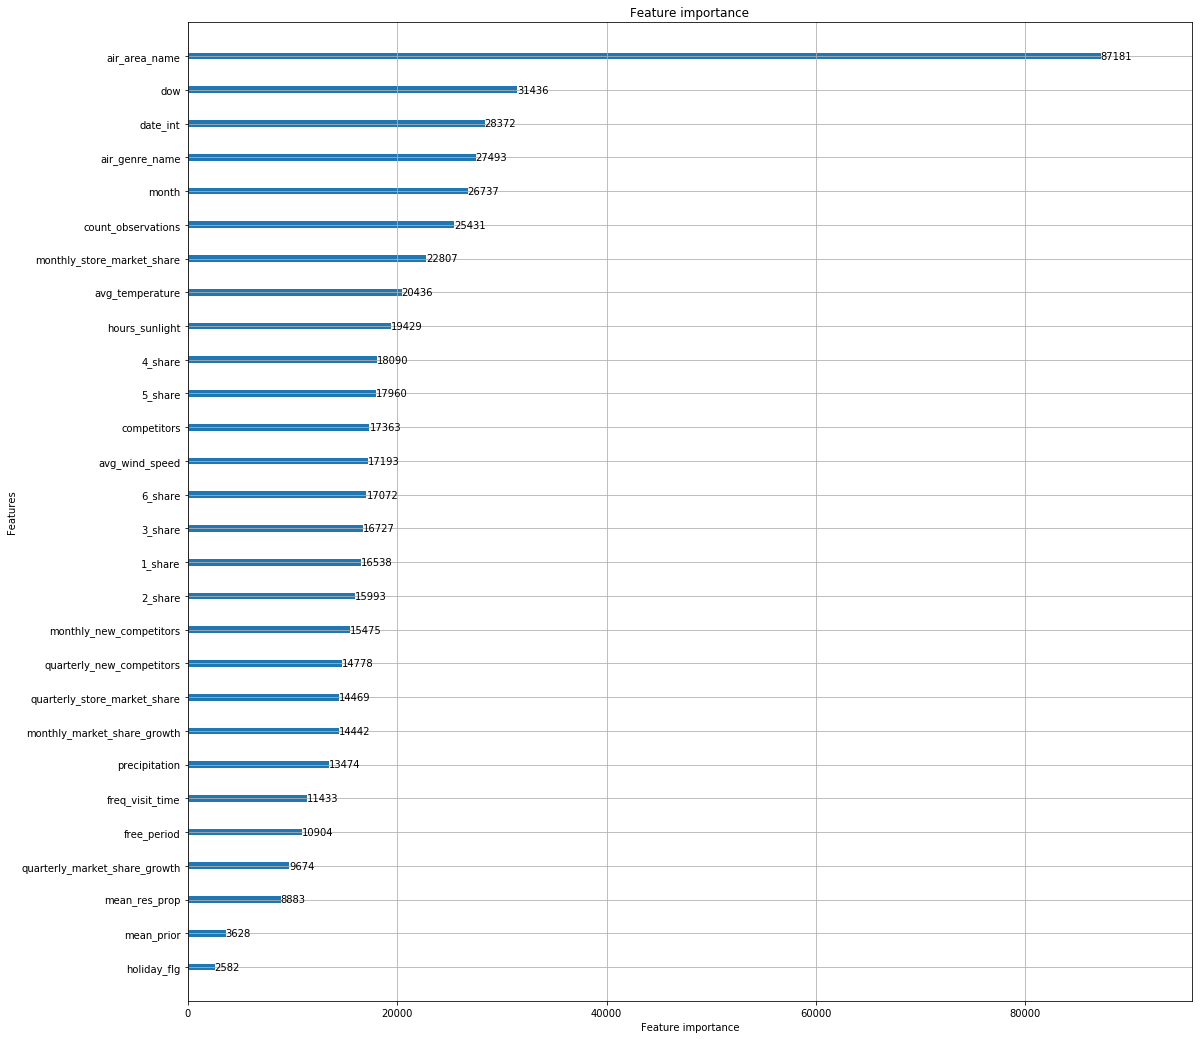

In [24]:
ax = lgb.plot_importance(gbm, max_num_features=34,figsize=(18,18))
plt.show()

In [25]:
df['test'][['id','visitors']].to_csv('new_submission_17.csv', index=False)